In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
import datetime


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
year = 2021
df = pd.read_csv(os.path.join(str(year), "./chicago_taxi_cleaned.csv"))
print("There are {} data points".format(len(df)))
df.columns

There are 3299523 data points


Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

In [4]:
# Converting trip start and trip end into datetime + extracting time information

dtformat = "%m/%d/%Y %I:%M:%S %p"
tformat = '%H:%M:%S'
dformat = "%m/%d/%Y"

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format=dtformat)
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format=dtformat)


df["Trip Start Time"] = df["Trip Start Timestamp"].dt.time
df["Trip End Time"] = df["Trip End Timestamp"].dt.time

df['date'] = df['Trip Start Timestamp'].dt.date
df['year'] = df['Trip Start Timestamp'].dt.year
df['month'] = df['Trip Start Timestamp'].dt.month
df['day'] = df['Trip Start Timestamp'].dt.day
df['hour'] = df['Trip Start Timestamp'].dt.hour
df['weekday'] = df['Trip Start Timestamp'].dt.day_name()


Firstly we try to visualize the trend of drivers and riders as the year progress

Text(0, 0.5, 'Number of Rides')

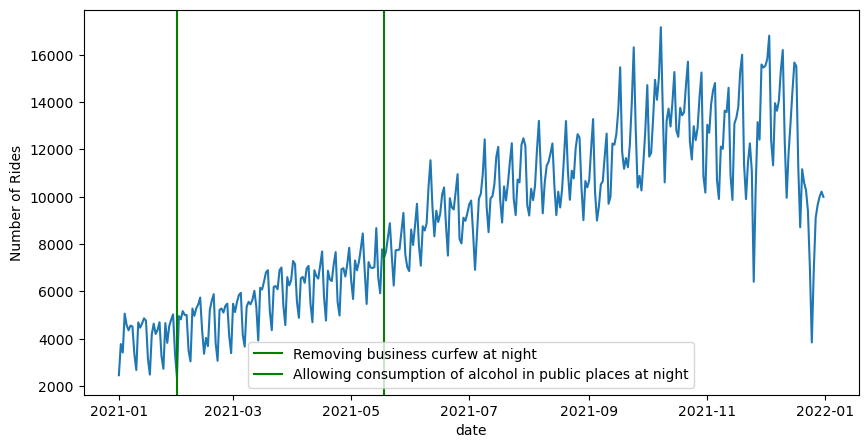

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
counts = df.groupby('date')['Trip ID'].count()
counts.plot(ax=ax, label="")

plt.axvline(datetime.datetime(2021, 5, 18), label='Removing business curfew at night', 
            color='green')
plt.axvline(datetime.datetime(2021, 1, 31), label='Allowing consumption of alcohol in public places at night', 
            color='green')

plt.legend()
plt.ylabel("Number of Rides")

Number of trips seem to go steadily as the year progresses. But this might also be influenced by covid restrictions. According to https://www.chicago.gov/city/en/sites/covid-19/home/health-orders.html we have the following guidelines from late 2020 to the entire 2021:

Restrictions:
- PUBLIC HEALTH ORDER No. 2020-3 (SECOND AMENDED AND REISSUED): Applying Governor's Stay-at-Home Executive Order (29-05-2020)
    - This prohibits gathering of more than 10 people
- PUBLIC HEALTH ORDER No. 2020-5 (AMENDED AND RE-ISSUED): Evening Cessation of Alcoholic Liquor Sales (30-10-2020)
    - This order maintains the closure of all liquor stores at 9pm, but it permits restaurants and bars to sell liquor as late as 11:00 p.m
- PUBLIC HEALTH ORDER No. 2020-11 (AMENDED AND RE-ISSUED): Non-essential Business Curfew (30-10-2020)
    - Also recommends avoiding gathering of more than 6 people
- QUARANTINE RESTRICTIONS ON PERSONS ENTERING CHICAGO FROM HIGH INCIDENCE STATES (11-11-2020)
- STAY-AT HOME-ADVISORY (16-11-2020)
- PUBLIC HEALTH ORDER No. 2020-5 (AMENDED AND RE-ISSUED): Cessation of Alcoholic Liquor Sales (02-03-2021)
- Masks Required Indoors in Public Places (20-08-2021)
- Proof of vaccination (21-12-2021)

Repeals:

- PUBLIC HEALTH ORDER No. 2020-11: Non-essential Business Curfew (31-01-2021)
- PUBLIC HEALTH ORDER No. 2020-9: Bridge Phase (AMENDED AND RE-ISSUED) (loosening of restrictions for fully vaccinated individuals, 18-05-2021)
- Repeal of alcoholic cessation in ORDER No. 2020-5 (18-05-2021)


So from the late 2020 through first half of 2021 there were restrictions in place regarding alcohol sales and bar opening hours as well as several gatherings and stay-at-home advisory and proof of vaccination which restricts people from entering public places. This seems to be elevated / relaxed as the year progresses. As a sanity check, we also load data from 2017 - 2019 and plot the overall trend

In [6]:
years = [2017, 2018, 2019, 2020]
df_over_years = {year: pd.read_csv(os.path.join(str(year), "./chicago_taxi_cleaned.csv"))
                 for year in years}
df_over_years[2021] = df

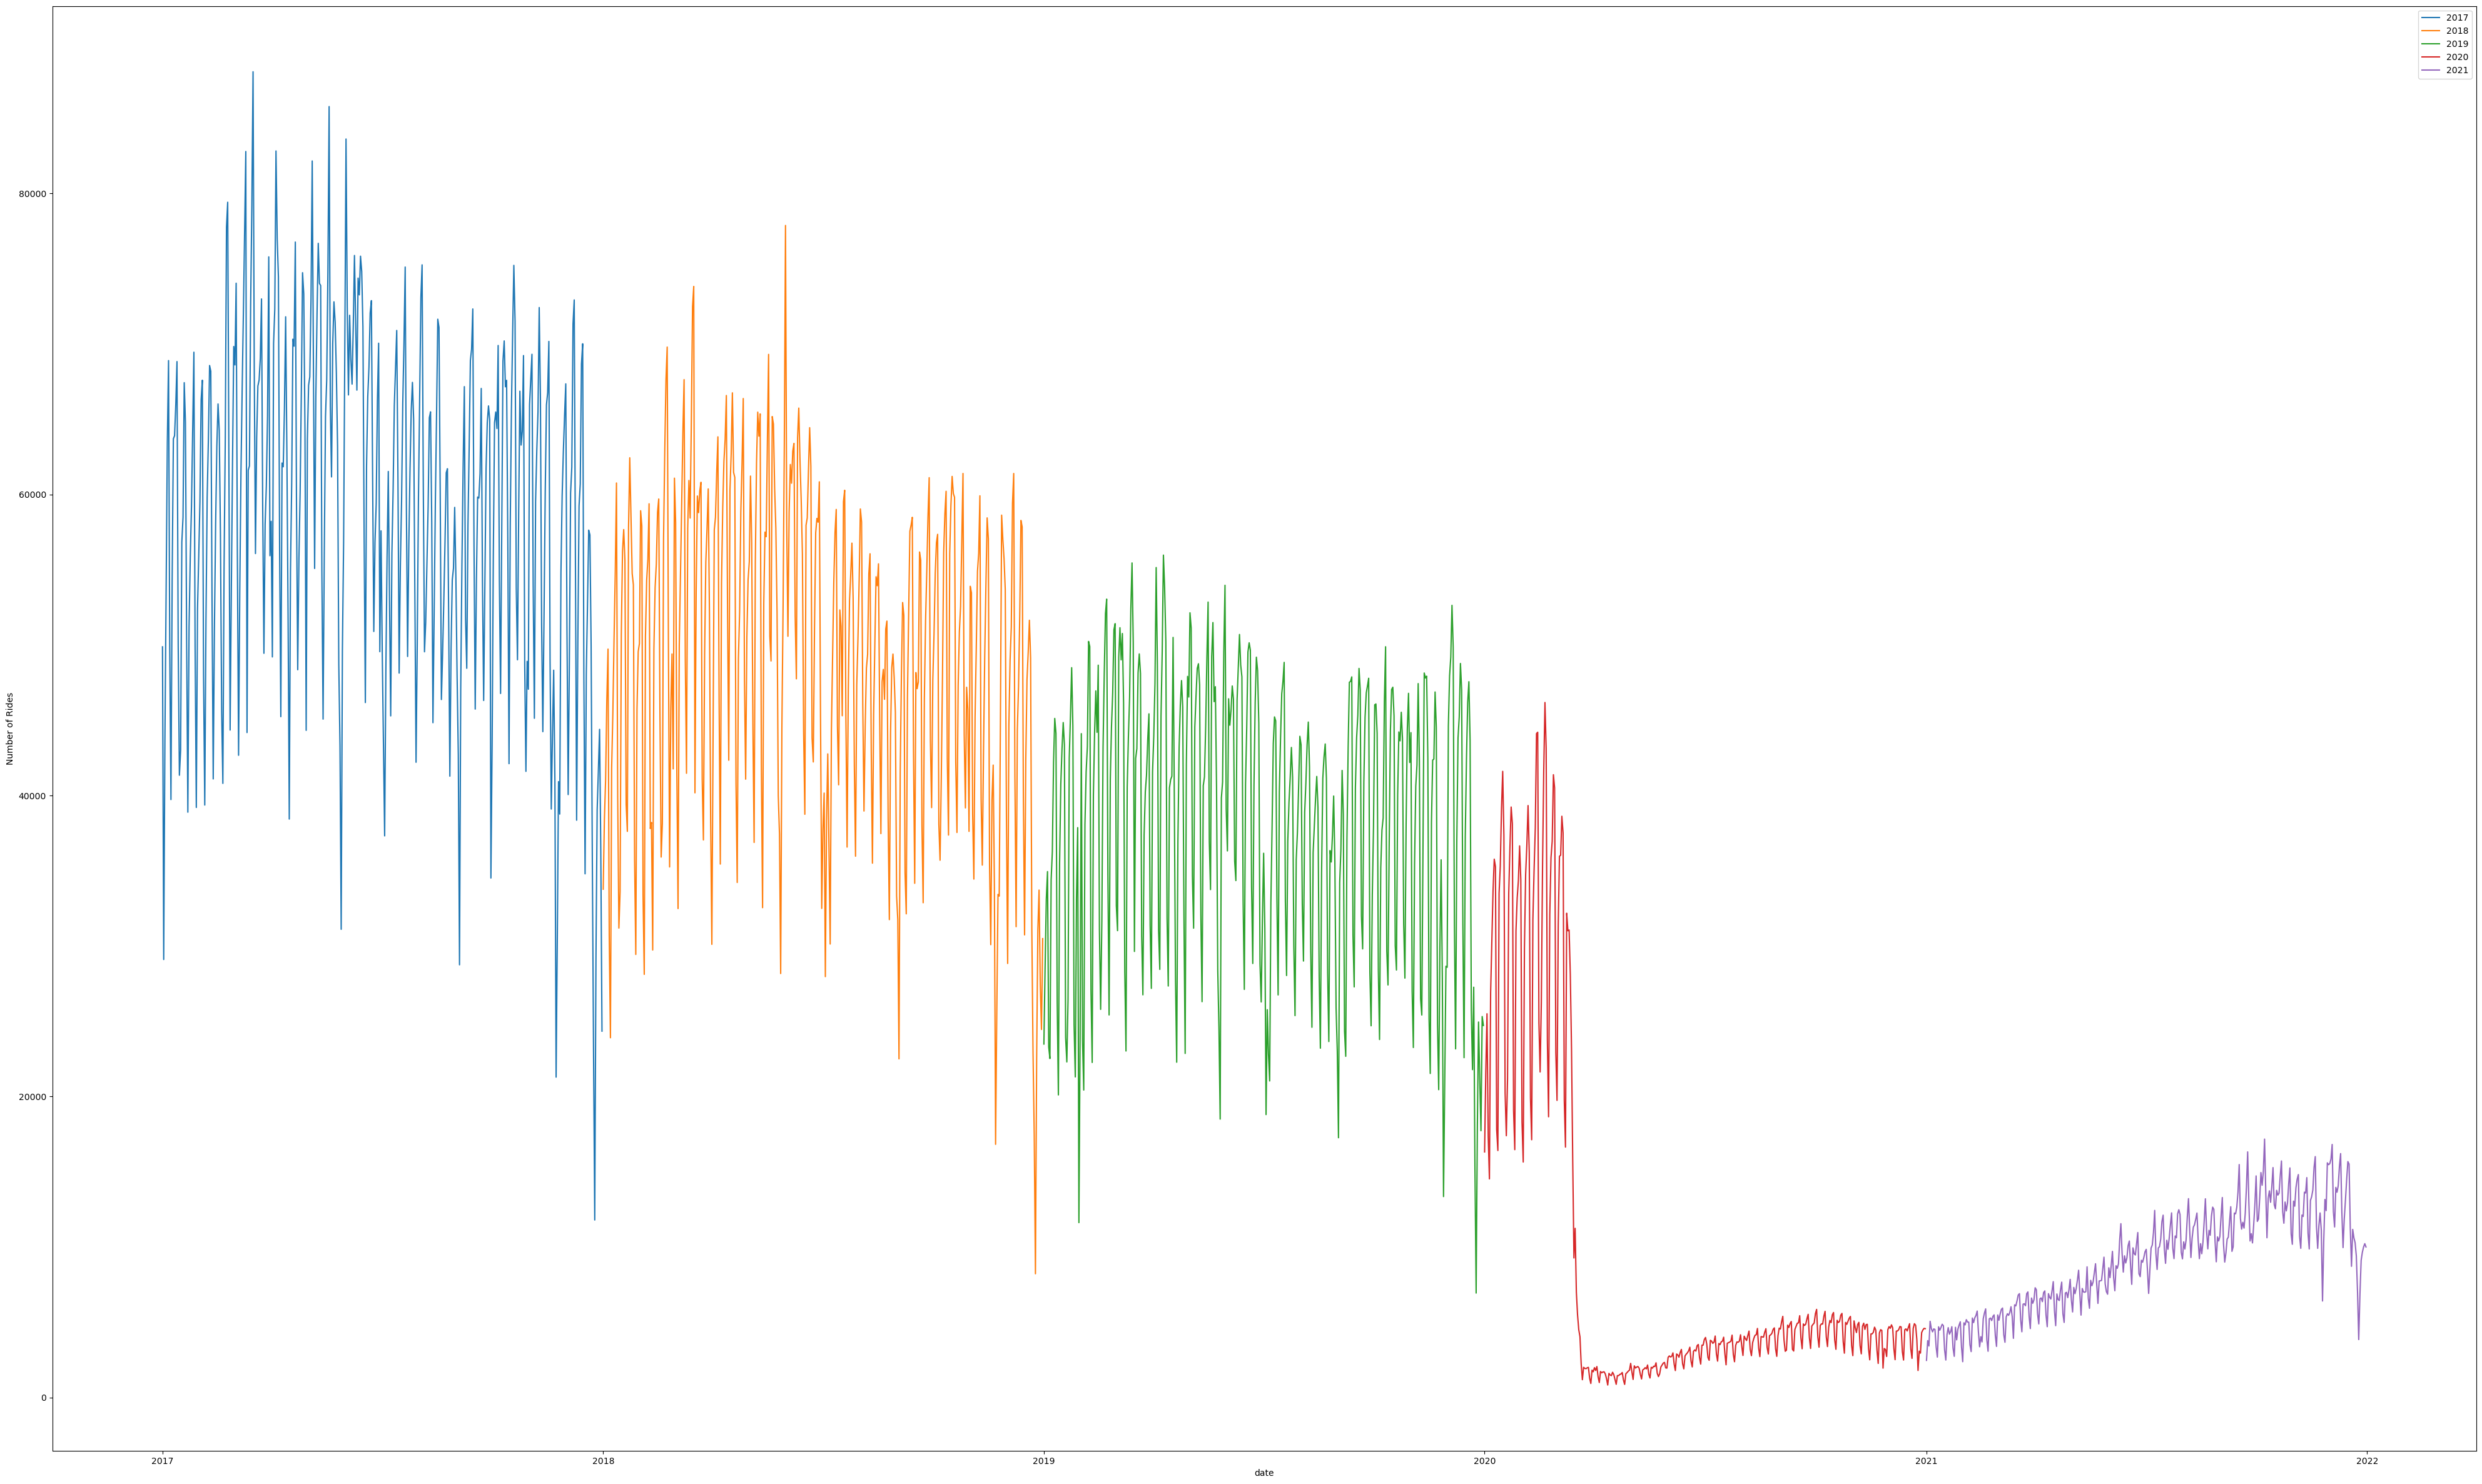

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(50, 30))

for year in years + [2021]:
    obs = df_over_years[year]
    obs["Trip Start Timestamp"] = pd.to_datetime(obs["Trip Start Timestamp"], format=dtformat)
    
    obs['date'] = obs['Trip Start Timestamp'].dt.date
    counts = obs.groupby('date')['Trip ID'].count()
    
    counts.plot(ax=ax, label=year)

    plt.legend()
    plt.ylabel("Number of Rides")
    

As we can see, there has been a sharp decrease in overall number of rides after covid. The increase can perhaps be attributed to the going back to normal with many restrictions being lifted. Nevertheless, the level of demand is still far below the normal level in 2017-2019. This should represents an opportunity to expand by capitalizing on the demand being restored to normal. Other than that, we should also check if the same trend in 2021 that involves seasonality matches the trend in other years as well

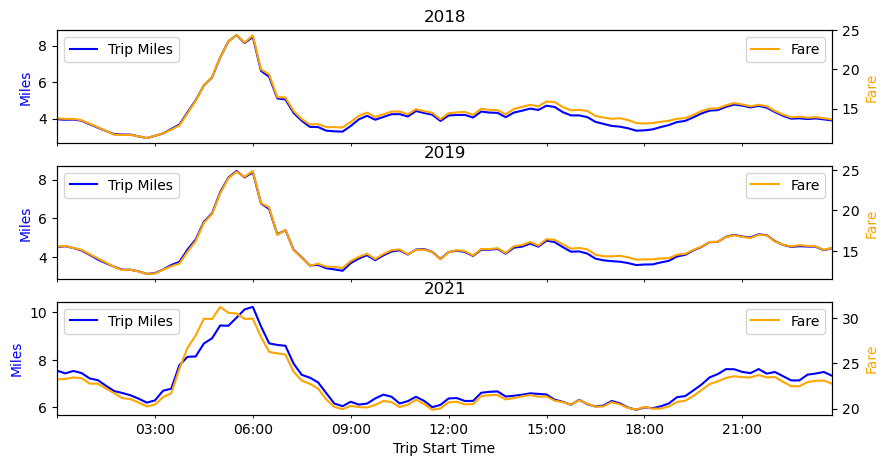

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

for year, ax in zip([2018, 2019, 2021], axes):
    obs = df_over_years[year]
    
    if "Trip Start Time" not in obs.columns:
        obs["Trip Start Time"] = obs["Trip Start Timestamp"].dt.time

    dollars_and_dist = obs.groupby("Trip Start Time")[["Fare", "Trip Miles"]]\
        .mean().reset_index()

    # We need to trick the column to display the hour as if they are from a single day

    dollars_and_dist["Trip Start Time"] = dollars_and_dist["Trip Start Time"]\
        .apply(lambda x: datetime.datetime.combine(datetime.date.today(), x))

    dollars_and_dist.plot(x="Trip Start Time", y="Trip Miles", ax=ax, color='blue', label="Trip Miles")
    ax.set_ylabel('Miles', color='blue')
    ax.set_title(year)
    ax.legend(loc=2)
    ax2 = ax.twinx()
    dollars_and_dist.plot(x="Trip Start Time", y="Fare", ax=ax2, color='orange', label="Fare")
    ax2.set_ylabel('Fare', color='orange')
    ax2.legend(loc=1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator())


The hourly patterns seem consistent across the year despite the irregularities in 2021. The hourly average fares fluctuates up to \$10 a day and it is directly proportional to the miles traveled and peak in the morning. Similarly, the number of drivers on the road follow this exact same trend as shown below:

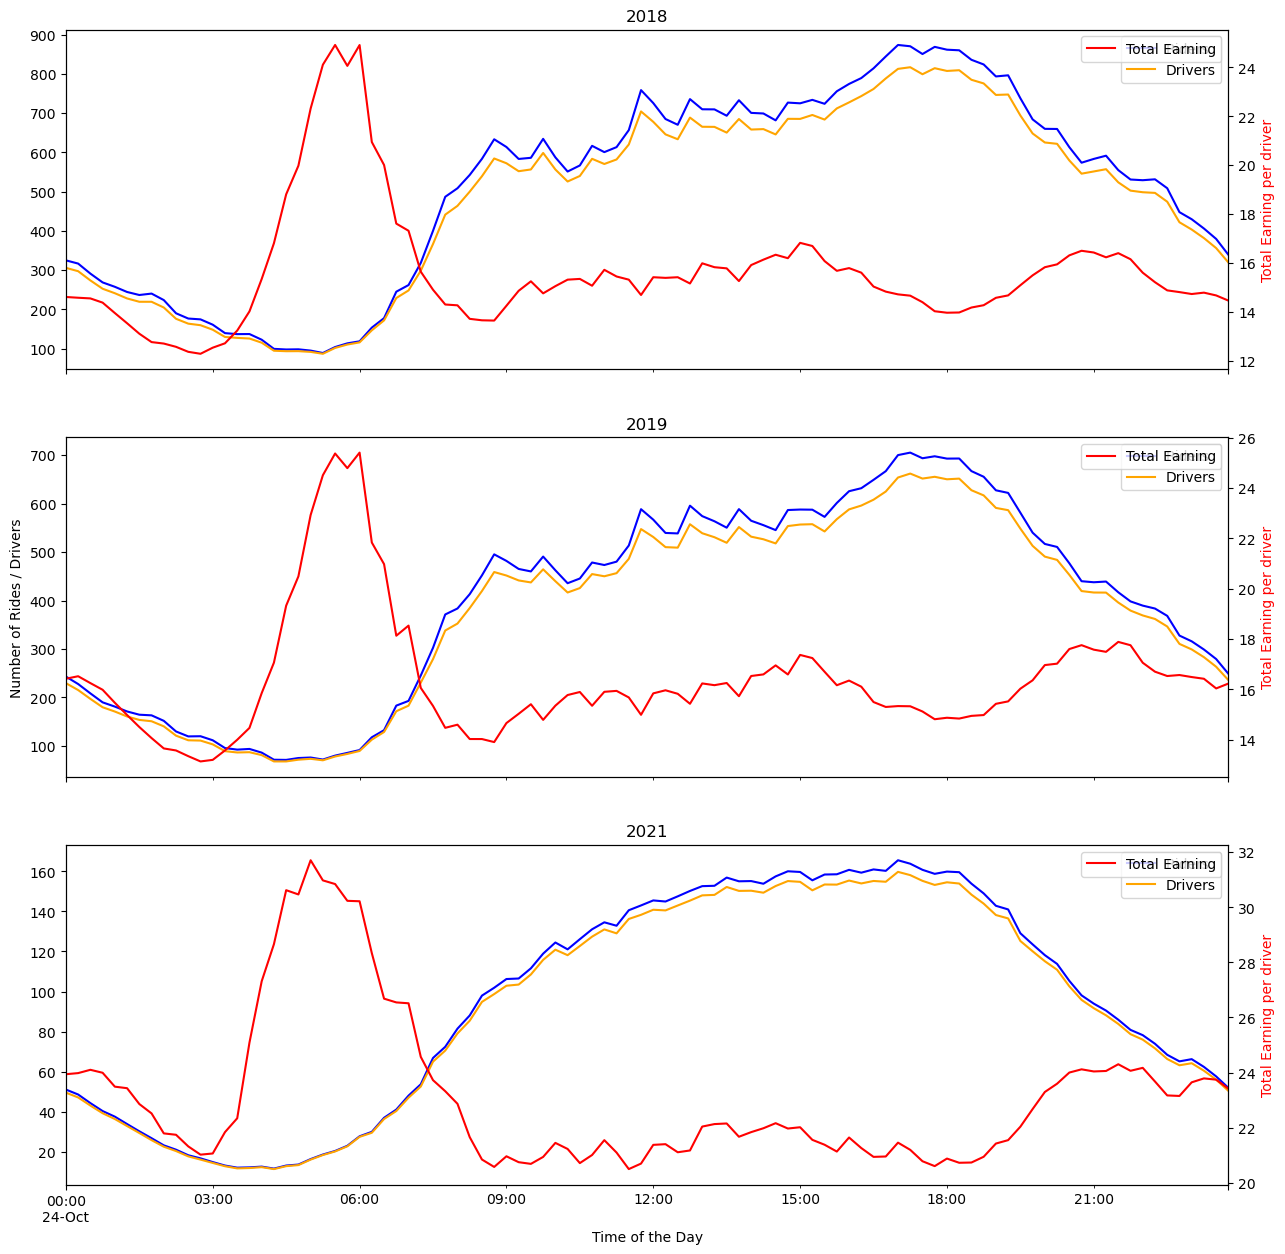

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
for year, ax, i in zip([2018, 2019, 2021], axes, np.arange(3)):
    
    obs = df_over_years[year]
    counts = obs.groupby(["Trip Start Time", 'date'])[['Trip ID', 'Taxi ID']].nunique().groupby('Trip Start Time')\
        .mean().reset_index().rename(columns={'Trip ID': 'Number of Rides', 'Taxi ID': 'Number of Drivers'})

    # Counting the average total fares each driver earns at each 15 minutes interval of the day across the year
    fares = obs.groupby(["Trip Start Time", 'date', 'Taxi ID'])[['Fare']].sum().groupby('Trip Start Time')\
        .mean().reset_index()

    # We need to trick the column to display the hour as if they are from a single day

    counts["Trip Start Time"] = counts["Trip Start Time"]\
        .apply(lambda x: datetime.datetime.combine(datetime.date.today(), x))

    fares["Trip Start Time"] = fares["Trip Start Time"]\
        .apply(lambda x: datetime.datetime.combine(datetime.date.today(), x))

    counts.plot(x="Trip Start Time", y='Number of Rides', ax=ax, color='blue', label="Riders")
    counts.plot(x="Trip Start Time", y='Number of Drivers', ax=ax, color='orange', label= "Drivers")
    ax.legend(loc=2)
    
    if i != 1:
        ax.set_ylabel("")
        ax.set_xlabel("")
    else:
        ax.set_ylabel('Number of Rides / Drivers')
        
    ax.set_title(year)
    ax.set_xlabel('Time of the Day')
    ax2 = ax.twinx()
    fares.plot(x="Trip Start Time", y="Fare", ax=ax2, color='red', label="Total Earning")
    ax2.set_ylabel('Total Earning per driver', color='red')

plt.legend()

General trend seems to be the same between 2018, 2019 compared against 2021 but the number of rides and the number of drivers are definitely much lower. In the morning, there is almost one taxi driver for every rider but this gap seems to widen during the day. This suggests that people are more willing to pay for taxi at the later part of the day and the supply of drivers do not rise nearly enough to accomodate the increase in riders. Perhaps this is also explained by the decrease in total earning per driver as the day progresses despite the high volume of rides, which is maybe explained by riders taking shorter trips during the day

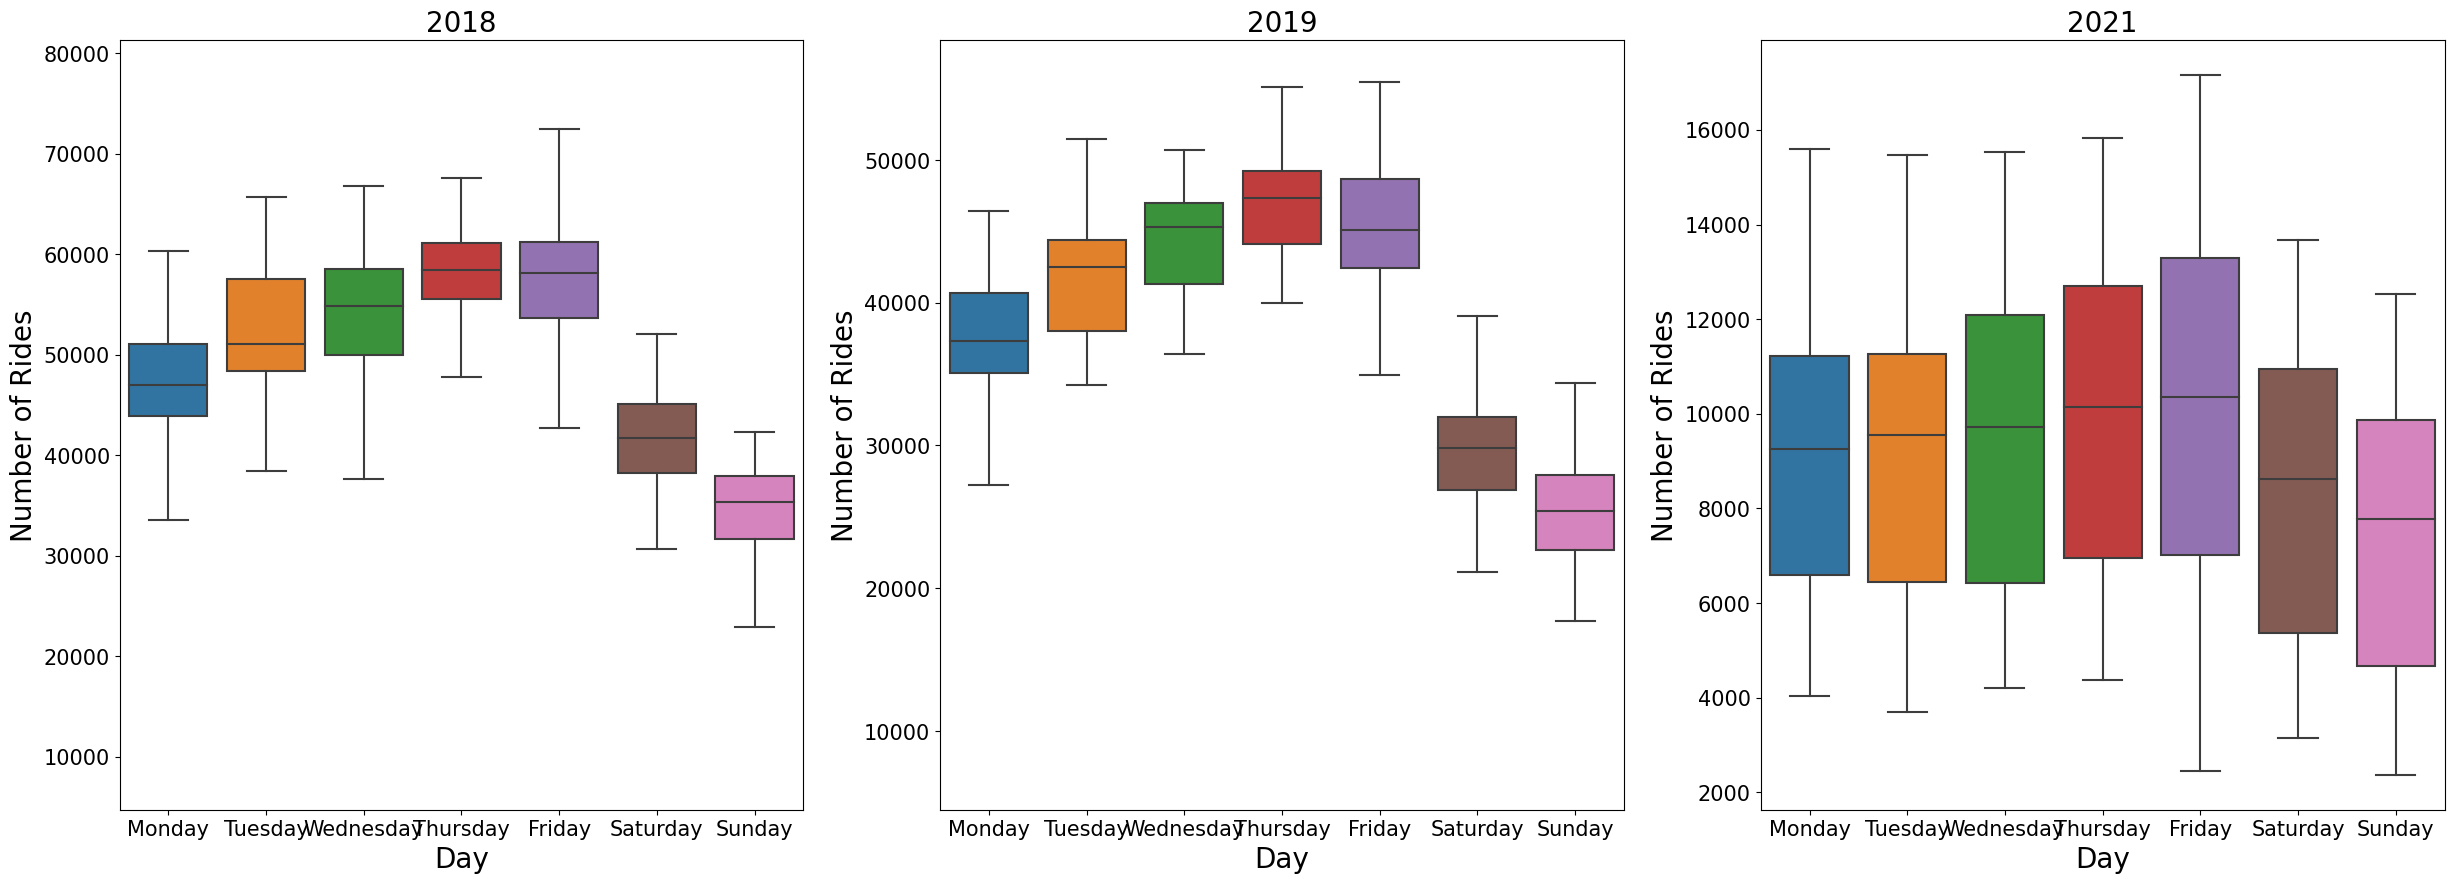

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
day_orders = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for year, ax in zip([2018, 2019, 2021], axes):
    obs = df_over_years[year]
    if "weekday" not in obs.columns:
        obs['weekday'] = obs['Trip Start Timestamp'].dt.day_name()

    sns.boxplot(x="weekday", y="Trip ID", data=obs.groupby(['weekday', 'date'])['Trip ID']\
                    .nunique().reset_index(), 
                ax=ax, order=day_orders, fliersize=0)
    ax.set_title(year, fontdict={'fontsize': 20})
    ax.set_xlabel("Day")
    ax.set_ylabel('Number of Rides')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    for axis in [ax.xaxis, ax.yaxis]:
        for tick in axis.get_major_ticks():
            tick.label.set_fontsize(15)

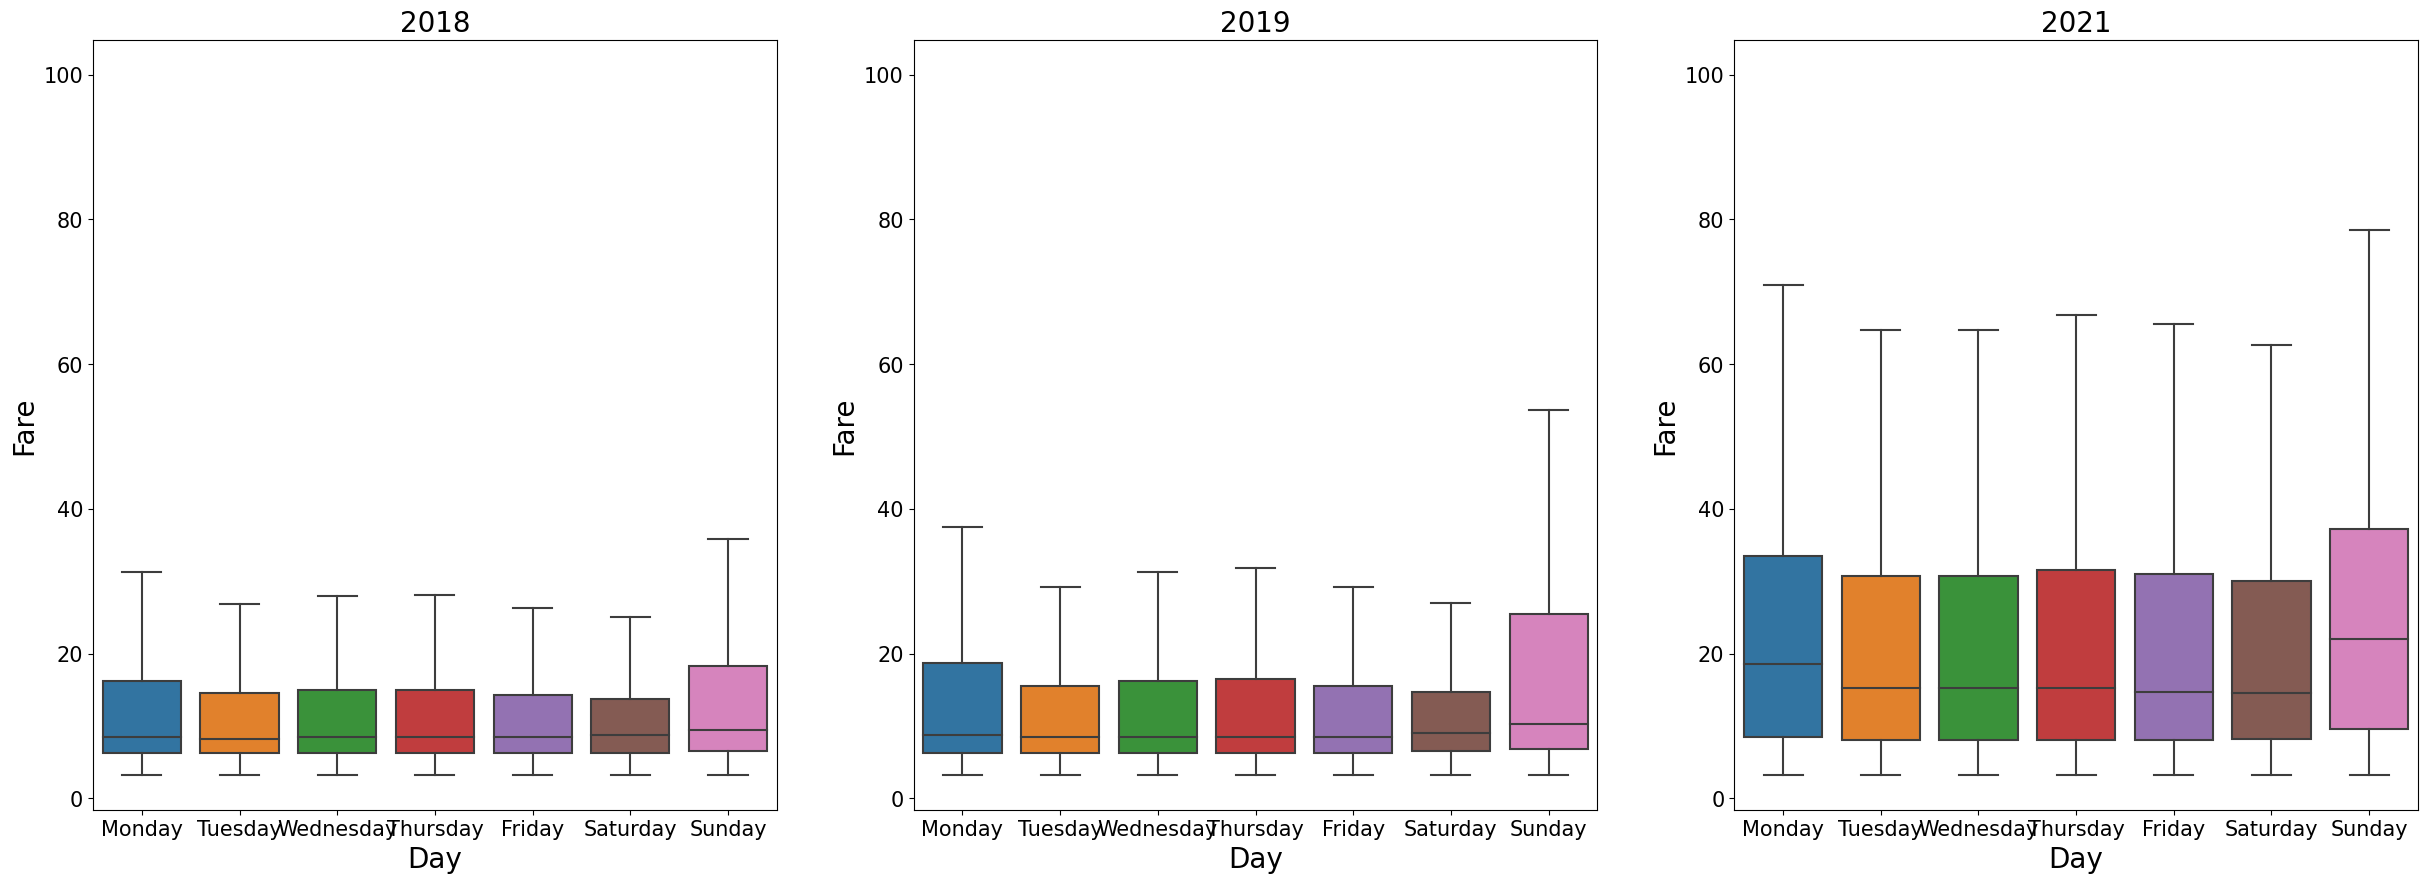

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
day_orders = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for year, ax in zip([2018, 2019, 2021], axes):
    obs = df_over_years[year]
    if "weekday" not in obs.columns:
        obs['weekday'] = obs['Trip Start Timestamp'].dt.day_name()

    sns.boxplot(x="weekday", y="Fare", data=obs, 
                ax=ax, order=day_orders, fliersize=0)
    ax.set_title(year, fontdict={'fontsize': 20})
    ax.set_xlabel("Day")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    for axis in [ax.xaxis, ax.yaxis]:
        for tick in axis.get_major_ticks():
            tick.label.set_fontsize(15)

In general fare level seems to be constant regardless of the day of the week. However there are fewer rides during the weekends in 2018 and 2019 but the difference is not significant enough in 2021 which might be confounded

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


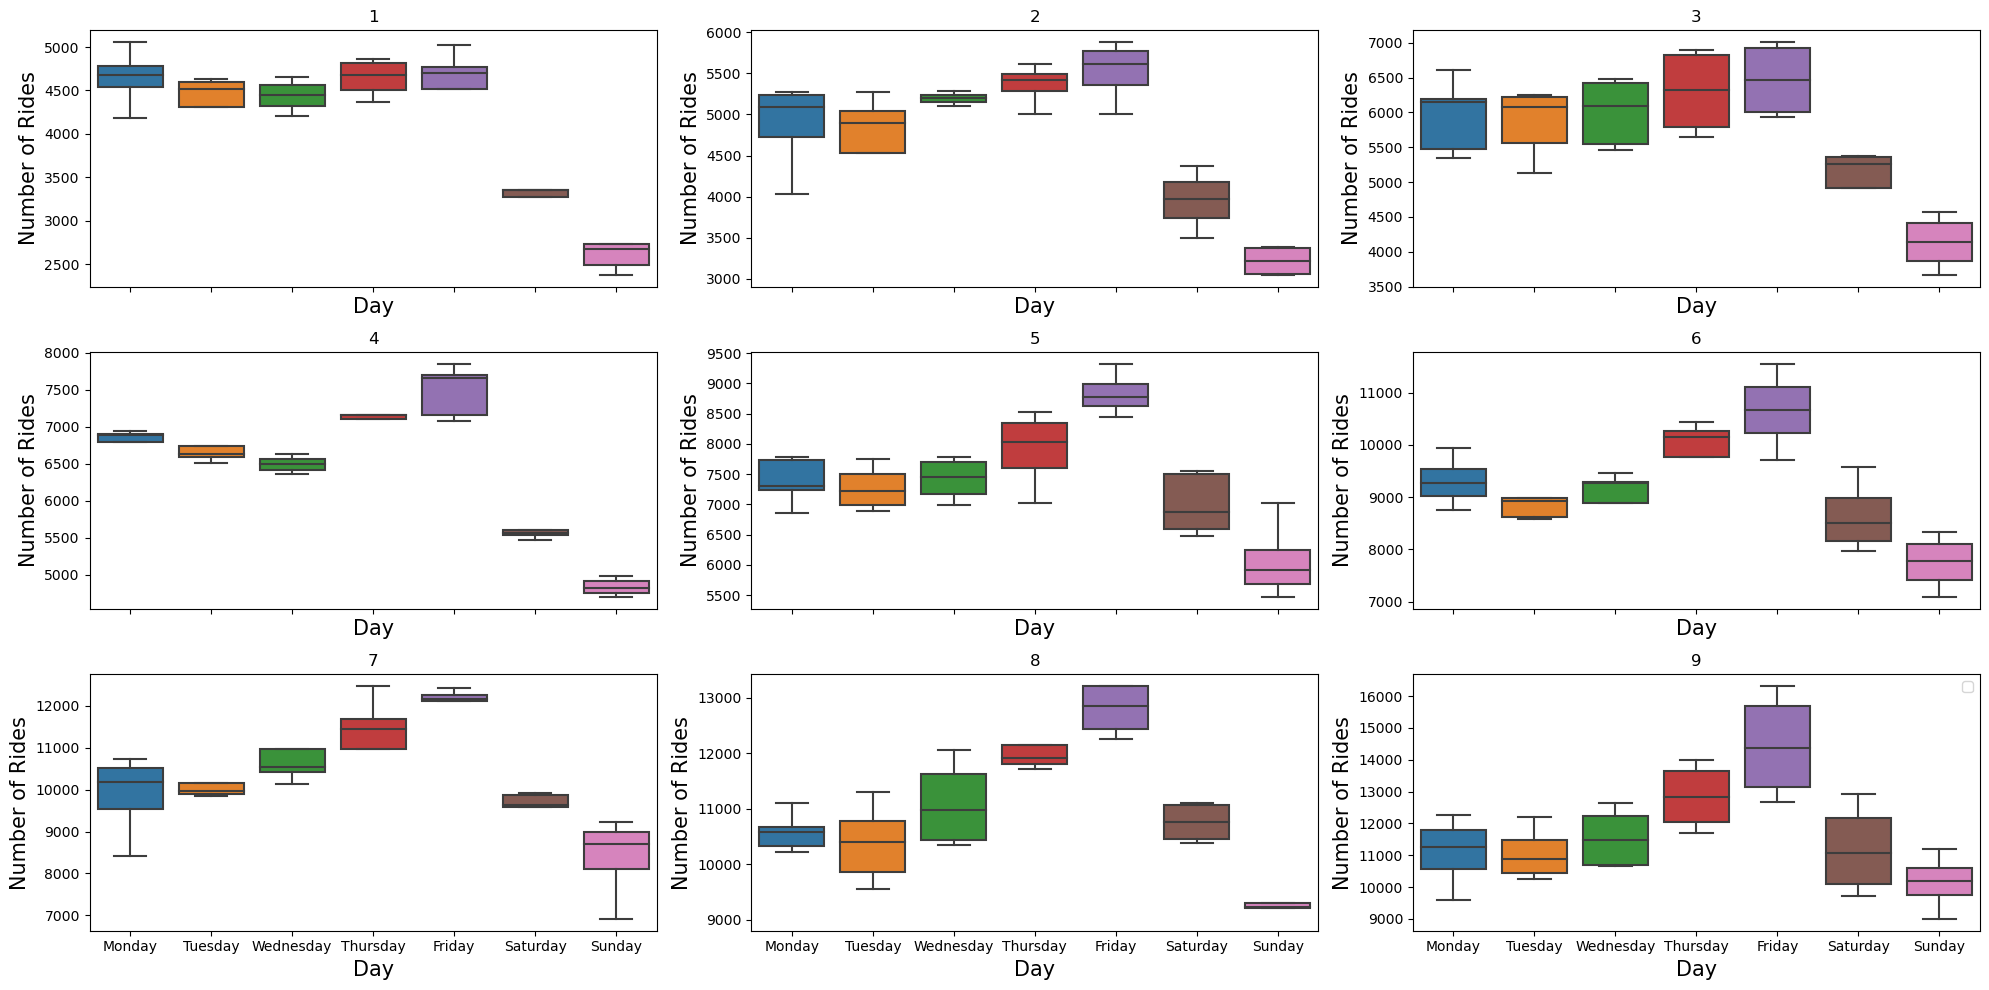

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True)
day_orders = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
k = 1
for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        sns.boxplot(x="weekday", y="Trip ID", 
                    data=df[df["month"] == k].groupby(['weekday', 'date'])['Trip ID']\
                        .nunique().reset_index(), 
                    ax=ax, order=day_orders, fliersize=0)
        ax.set_ylabel('Trip Numbers')
        ax.set_title(k, fontdict={'fontsize': 12})
        ax.set_xlabel("Day")
        ax.set_ylabel('Number of Rides')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(10)
        k += 1

plt.legend()
plt.tight_layout()

As evidenced, the difference in weekend number of rides are apparent when we look at each month separately. Next we want to look at some of the major players in the industry at see if their share of rides have changed over the year. Next we want to look at the market share of the taxi companies

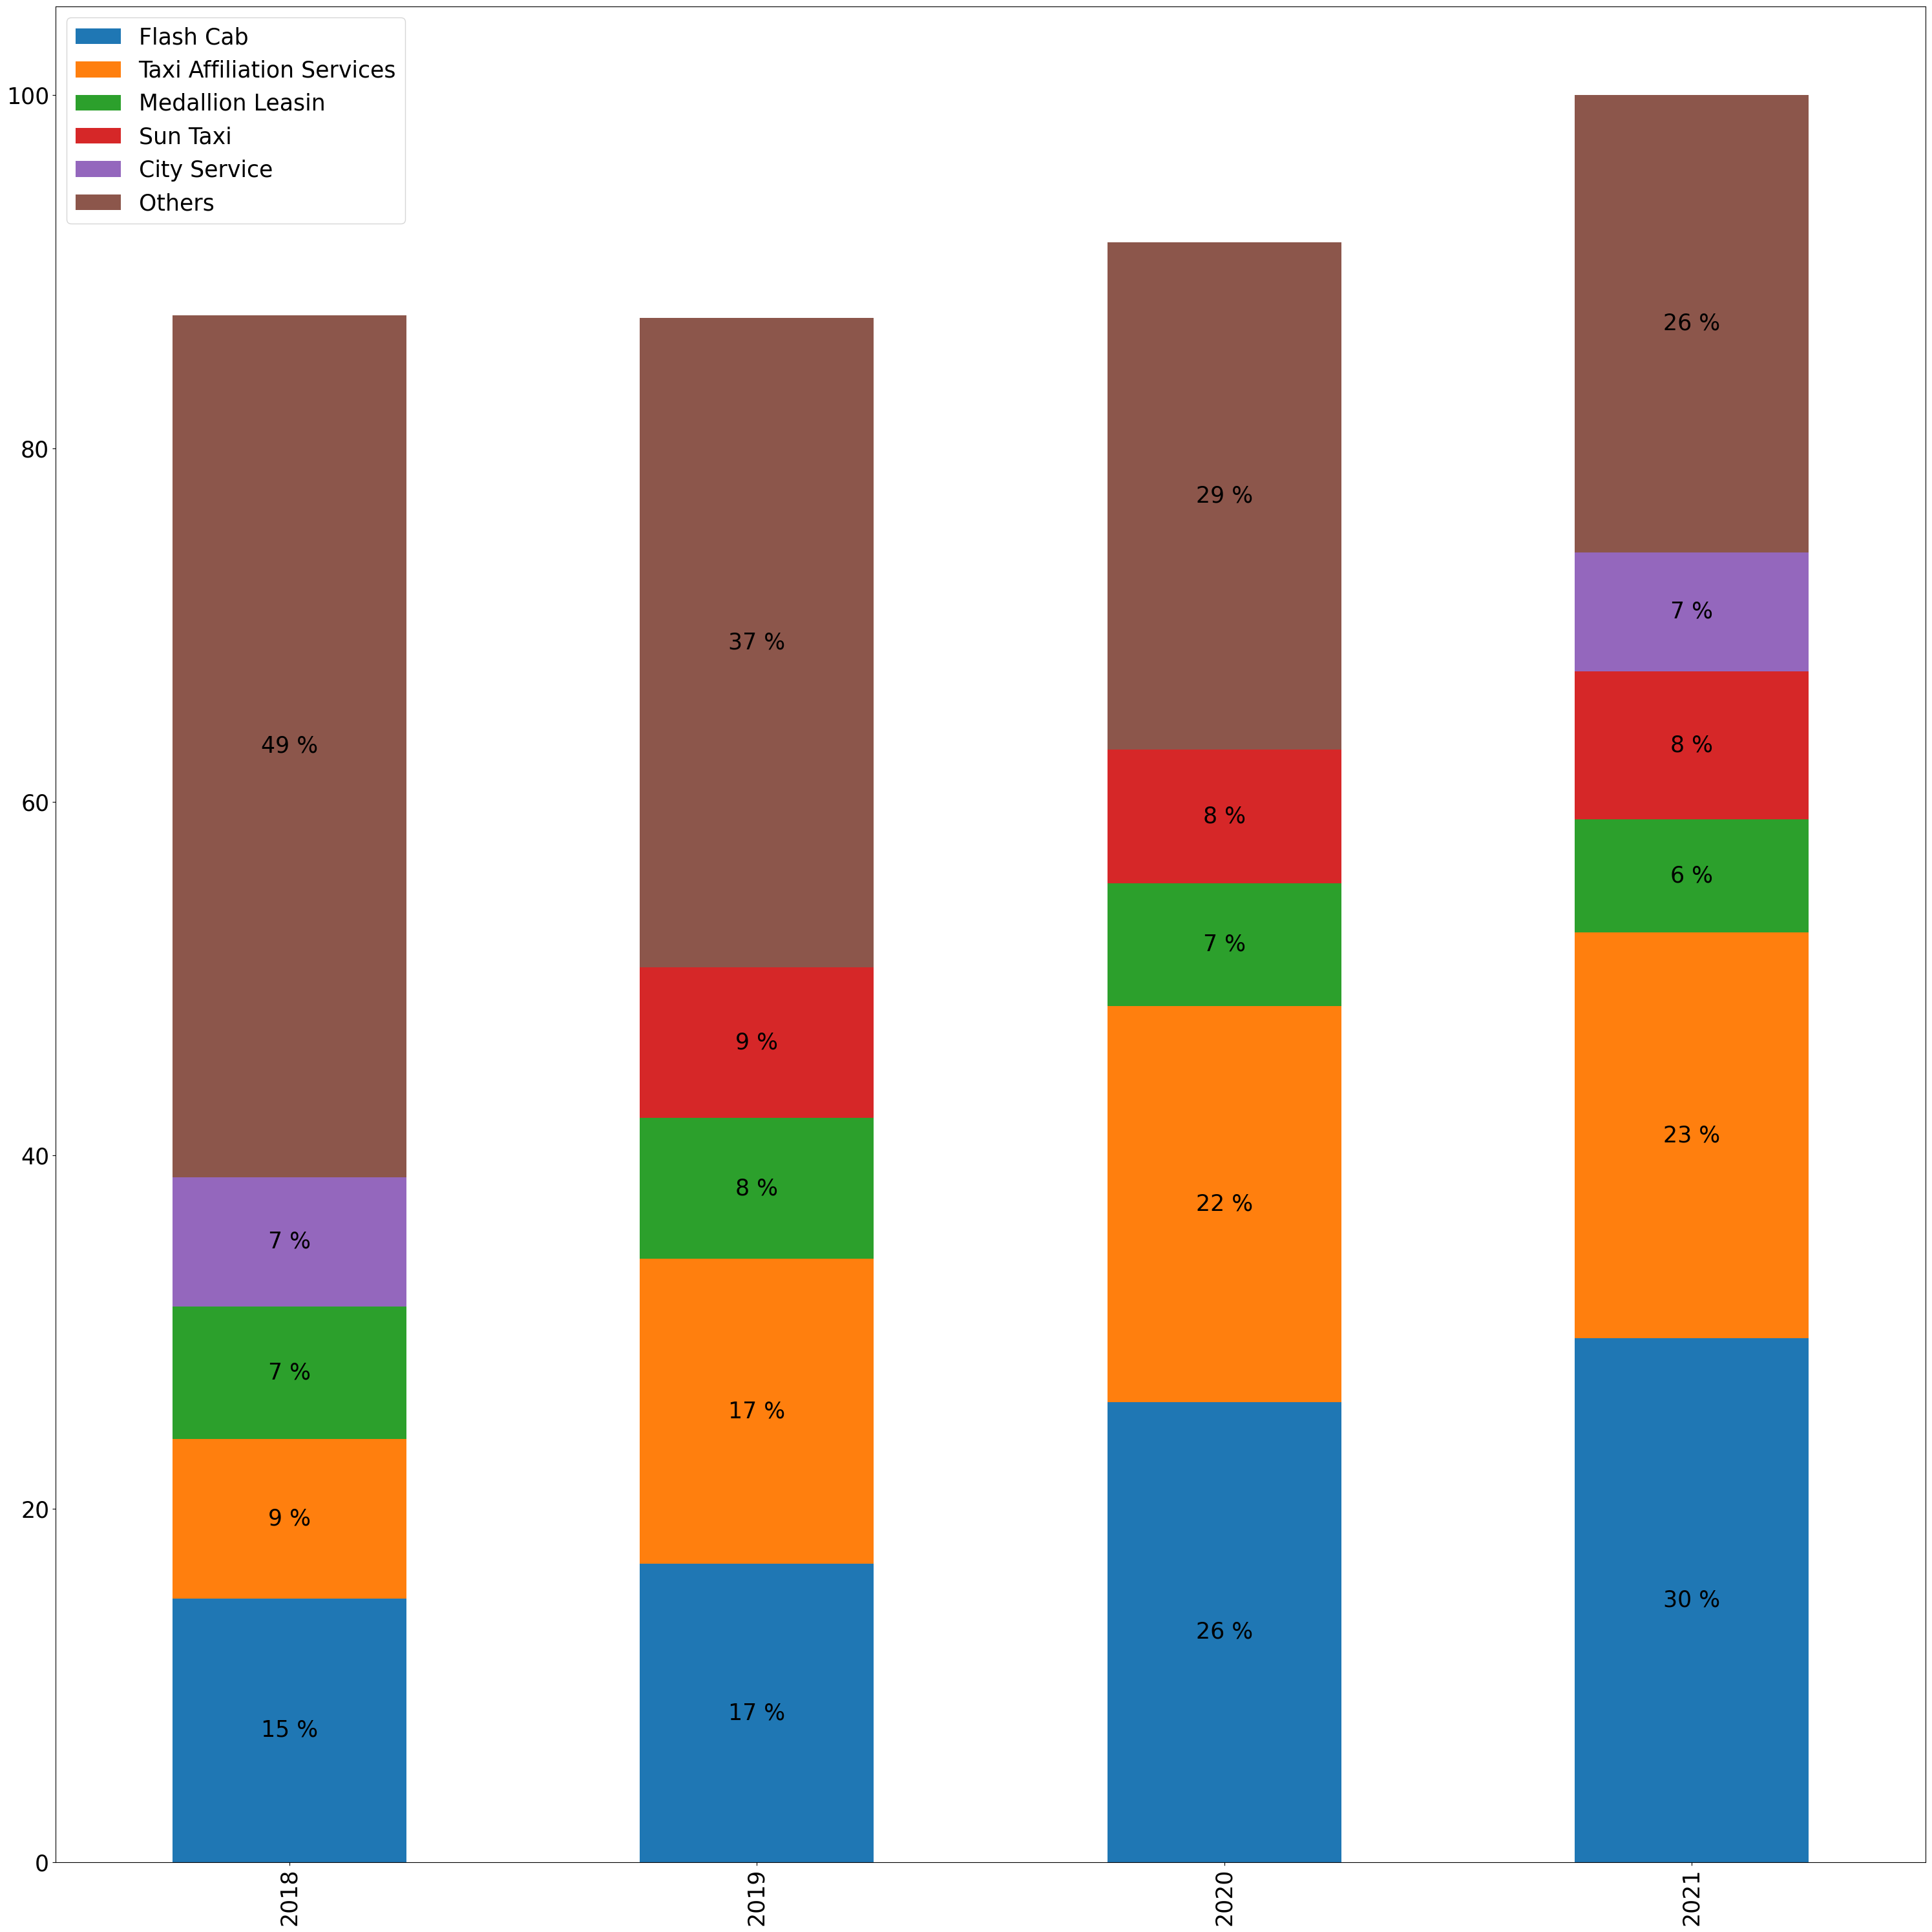

In [13]:
all_years = []
all_companies = []
all_percentages = []

companies = {}
top_n = 5
for year in [2018, 2019, 2020, 2021]:
    obs = df_over_years[year]
    companies, rides = np.unique(obs["Company"], return_counts=True)
    companies, rides = companies[np.argsort(-rides)], rides[np.argsort(-rides)]
    companies = np.append(companies[:top_n], ["Others"])

    rides = np.append(rides[:top_n], [np.sum(rides[top_n:])])
    rides = rides * 100 / np.sum(rides)
    
    all_companies.append(companies)
    all_years.append(np.repeat(year, len(companies)))
    all_percentages.append(rides)

all_years = np.concatenate(all_years)
all_companies = np.concatenate(all_companies)
all_percentages = np.concatenate(all_percentages)

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
company_df = {}
order = ['Flash Cab', 'Taxi Affiliation Services', 'Medallion Leasin', 'Sun Taxi', 
         'City Service', 'Others']
for company in np.unique(all_companies):
    company_df[company] = {}

for year, company, pct in zip(all_years, all_companies, all_percentages):
    company_df[company][year] = pct
company_df = pd.DataFrame(company_df)[order]
company_df.plot(kind='bar', stacked=True, ax=ax)

font_size = 25

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center', fontdict={'fontsize': font_size})

ax.xaxis.label.set_size(font_size)
ax.yaxis.label.set_size(font_size)

plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)
        
ax.legend(loc='best', prop={'size': font_size})
plt.tight_layout()

Seems like pre-covid the market shares in 2018 are distributed more evenly as evidenced by the collective market shares of smaller taxi companies and as the year progresses they consolidate to a couple of big companies. It is worth noting that the consolidation seems to be sped up during the height of the pandemic and lastly in 2021, most of the market shares of the smaller companies seem to go to Flash Cab and Taxi Affiliation Services. Let's take a look at the trend of payment type changes across these companies

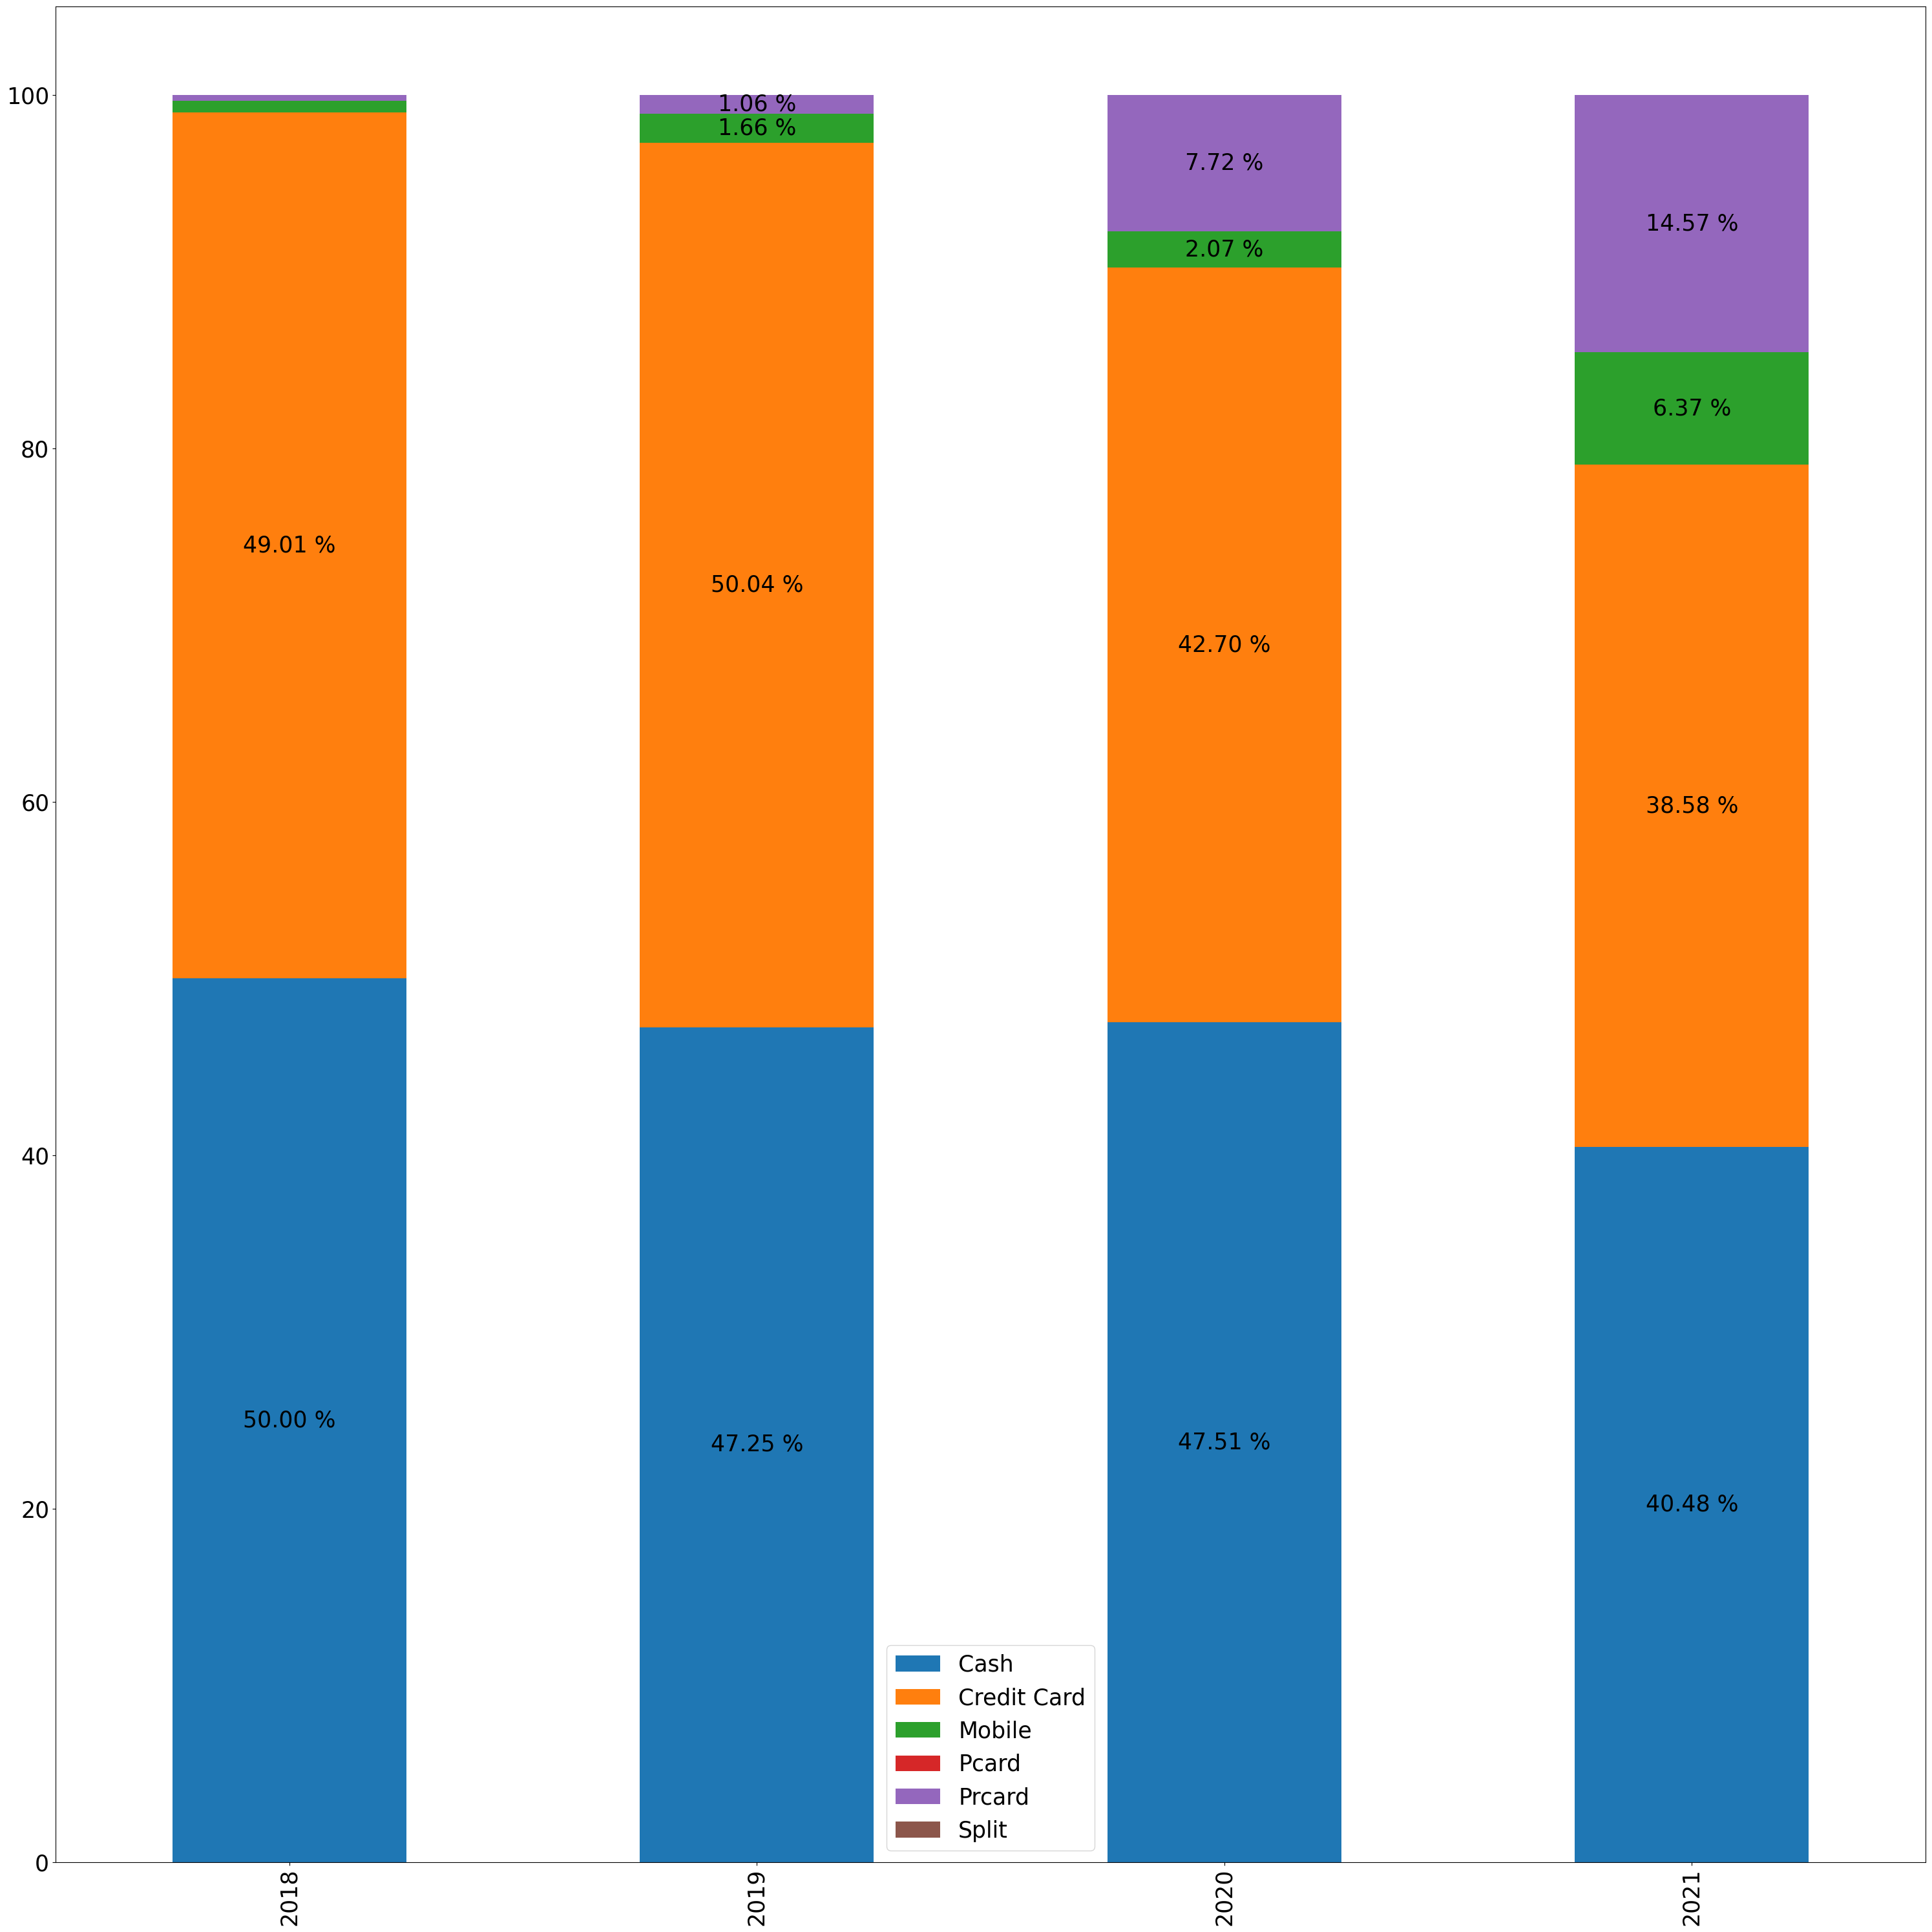

In [14]:
def normalize_payment_count(df):
    df["Payment Share"] /= df["Payment Share"].sum()
    return df

all_payments = []
all_years = []
all_percentages = []

for year in [2018, 2019, 2020, 2021]:
    obs = df_over_years[year]
    obs = obs[~obs["Payment Type"].isin(['Dispute', 'No Charge', 'Unknown'])]
    payments, counts = np.unique(obs["Payment Type"], return_counts=True)
    counts = counts * 100 / np.sum(counts)
    
    all_payments.extend(payments)
    all_years.extend(np.repeat(year, len(payments)))
    all_percentages.extend(counts)
    

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
payment_df = {}

for payment in np.unique(all_payments):
    payment_df[payment] = {}

for year, payment, pct in zip(all_years, all_payments, all_percentages):
    payment_df[payment][year] = pct
    
payment_df = pd.DataFrame(payment_df)
payment_df.plot(kind='bar', stacked=True, ax=ax)

font_size = 25

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.2f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center', fontdict={'fontsize': font_size})

ax.xaxis.label.set_size(font_size)
ax.yaxis.label.set_size(font_size)

plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)
        
ax.legend(loc='best', prop={'size': font_size})
plt.tight_layout()

In general cash payment decreases slightly over the years with taxi companies and more customers prefer non cash options such as mobile payment or Prcard or credit card. Let us look at the individual breakdown

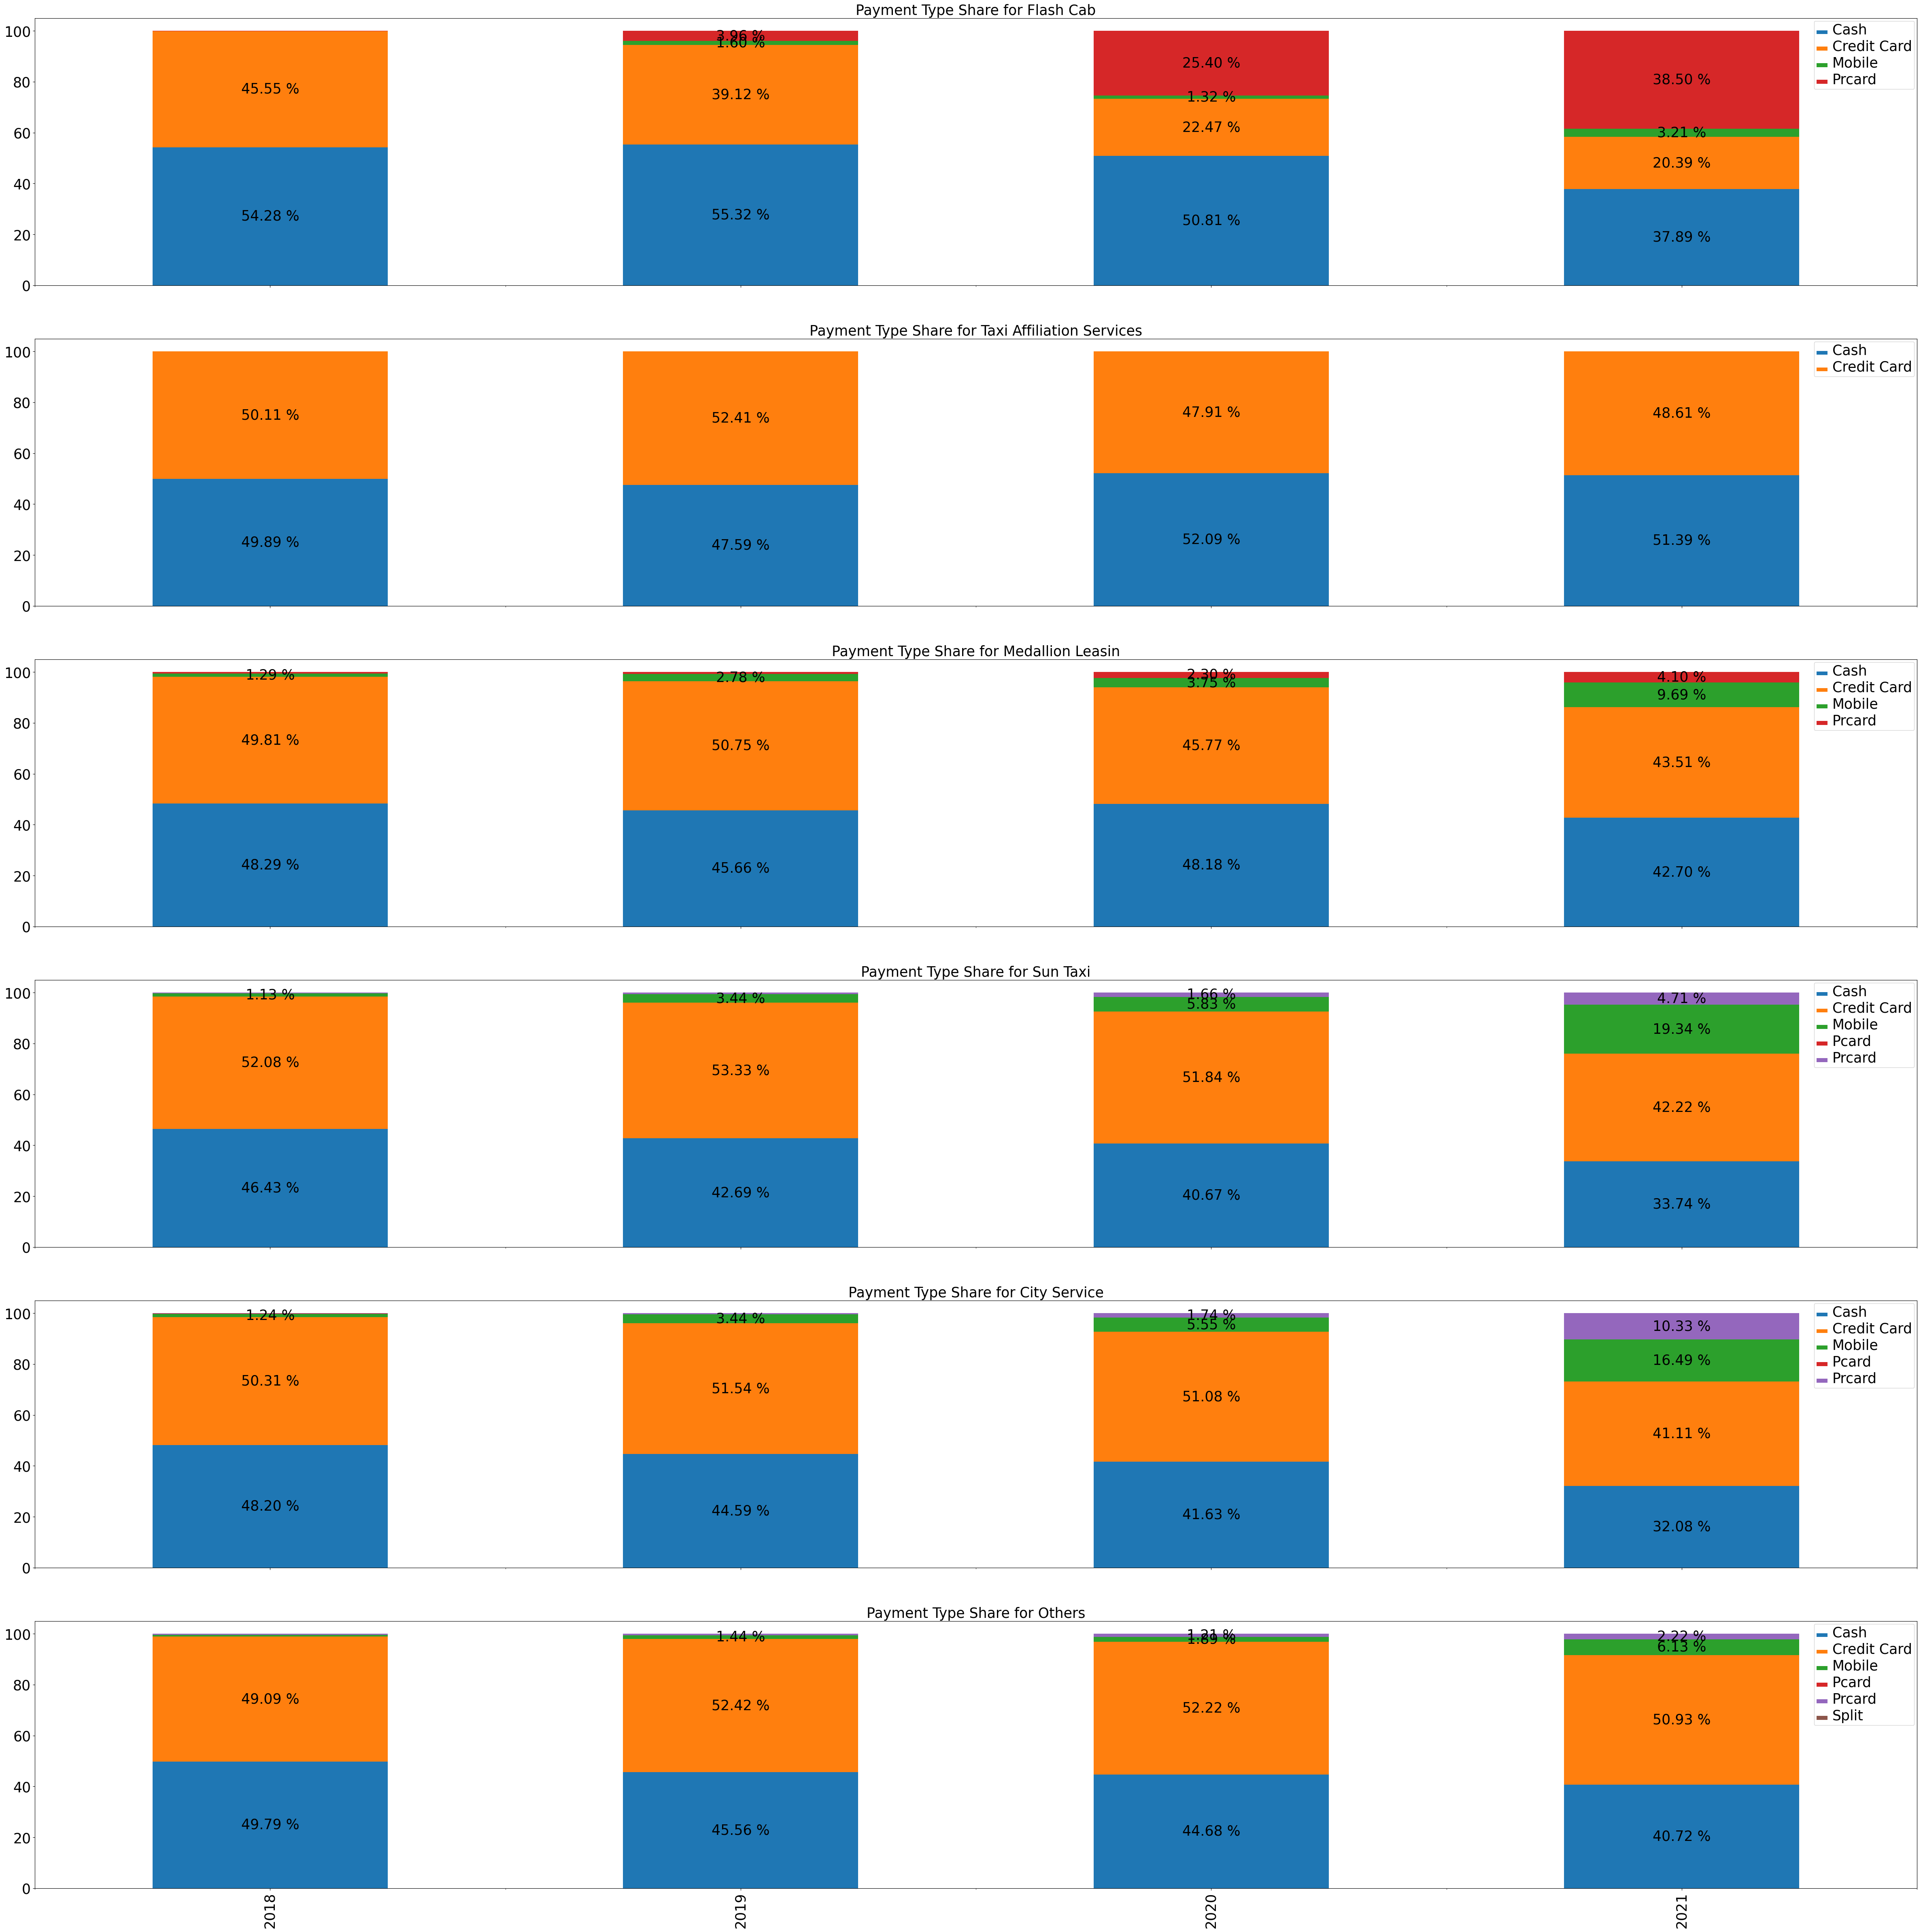

In [15]:
companies = ['Flash Cab', 'Taxi Affiliation Services', 'Medallion Leasin', 'Sun Taxi', 
             'City Service']

payment_df = []
for year in [2018, 2019, 2020, 2021]:
    obs = df_over_years[year]
    obs = obs[~obs["Payment Type"].isin(['Dispute', 'No Charge', 'Unknown'])]
    obs.loc[~obs["Company"].isin(companies), "Company"] = 'Others'
    
    count_by_payment = obs.groupby(["Company", "Payment Type"])["Trip ID"].count().reset_index()\
        .rename(columns={'Trip ID': 'Payment Share'})
    count_by_payment["Year"] = year
    count_by_payment = count_by_payment.groupby("Company").apply(normalize_payment_count)
    payment_df.append(count_by_payment)
    
payment_df = pd.concat(payment_df)

companies.append('Others')

fig, axes = plt.subplots(6, 1, figsize=(60, 60), sharex=True)
for company, ax in zip(companies, axes):
    all_payments = payment_df[payment_df["Company"] ==  company]["Payment Type"].unique()
    sub_payment = {ptype: [] for ptype in all_payments
                   }
    for year in [2018, 2019, 2020, 2021]:
        sub_df = payment_df[payment_df["Company"] == company]
        sub_df = sub_df[sub_df["Year"] == year]
        ptype_count = {ptype: count for ptype, count in zip(sub_df["Payment Type"], 
                                                            sub_df["Payment Share"])}
        for ptype in all_payments:
            if ptype in ptype_count:
                sub_payment[ptype].append(ptype_count[ptype] * 100)
            else:
                sub_payment[ptype].append(0)
                
    sub_payment = pd.DataFrame(sub_payment)
    sub_payment.index = [2018, 2019, 2020, 2021]
    sub_payment.plot(kind='bar', stacked=True, ax=ax)

    font_size = 25

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 1:
            x, y = p.get_xy()
            ax.text(x+width/2, 
                    y+height/2, 
                    '{:.2f} %'.format(height), 
                    horizontalalignment='center', 
                    verticalalignment='center', fontdict={'fontsize': font_size})

        ax.xaxis.label.set_size(font_size)
        ax.yaxis.label.set_size(font_size)
        ax.set_title('Payment Type Share for {}'.format(company), fontdict={'fontsize': font_size})
        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

#         ax.legend(loc='best', prop={'size': font_size})


# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')

In general most of the top performing companies have somewhat lower proportion of cash, followed by payment using Prcard or Pcard (except for taxi affiliation services). Most notably perhaps is Flash Cab that has the highest usage of Prcard proportion. This might suggest strong incentive from the riders to utilize this method of payment which results in them grabbing a significant percentage of the market share

In [28]:
import matplotlib
import geopandas as gpd

In [29]:
# Loading map of chicago

ca = gpd.read_file("./chicago_map.geojson")
ca['area_num_1'] = ca['area_num_1'].astype('int')

In [43]:
def visualize_community_trip_by_hour(df, geo_df, hours, mode='pickup'):
    if mode not in ('pickup', 'dropoff'):
        raise ValueError('mode must be one of pickup or dropoff')
    
    if mode == 'pickup':
        col = 'Pickup Community Area'
    else:
        col = 'Dropoff Community Area'
    
    fig, axes = plt.subplots(1, len(hours), figsize=(20, 10 * len(hours)))
    
    if "hour" not in df.columns:
        df["hour"] = df["Trip Start Timestamp"].dt.hour
    
    dat_ca = df.groupby([col, "hour"])["Trip ID"].count().reset_index()\
        .rename(columns={'Trip ID': 'Number of Trips'})
    dat_ca[col] = dat_ca[col].astype('int')
    
    merged_df = geo_df.merge(dat_ca, left_on='area_num_1', right_on=col)
    merged_df["center"] = merged_df["geometry"].centroid
    merged_df.fillna(value = 0, inplace=True)

    for hour, ax in zip(hours, axes):
        to_plot = merged_df[merged_df["hour"] == hour]
        to_plot.plot(column='Number of Trips', scheme='fisher_jenks', cmap='YlOrRd', 
                          edgecolor='black',
                          legend=True, ax=ax)
        for idx, row in to_plot.iterrows():
            ax.annotate(row['area_num_1'], (row['center'].x, row['center'].y),
                        horizontalalignment='center')
        ax.set_title('{} Distribution at {} hour'.format(col, hour), fontdict={'fontsize': 12})
    plt.tight_layout()
    



/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



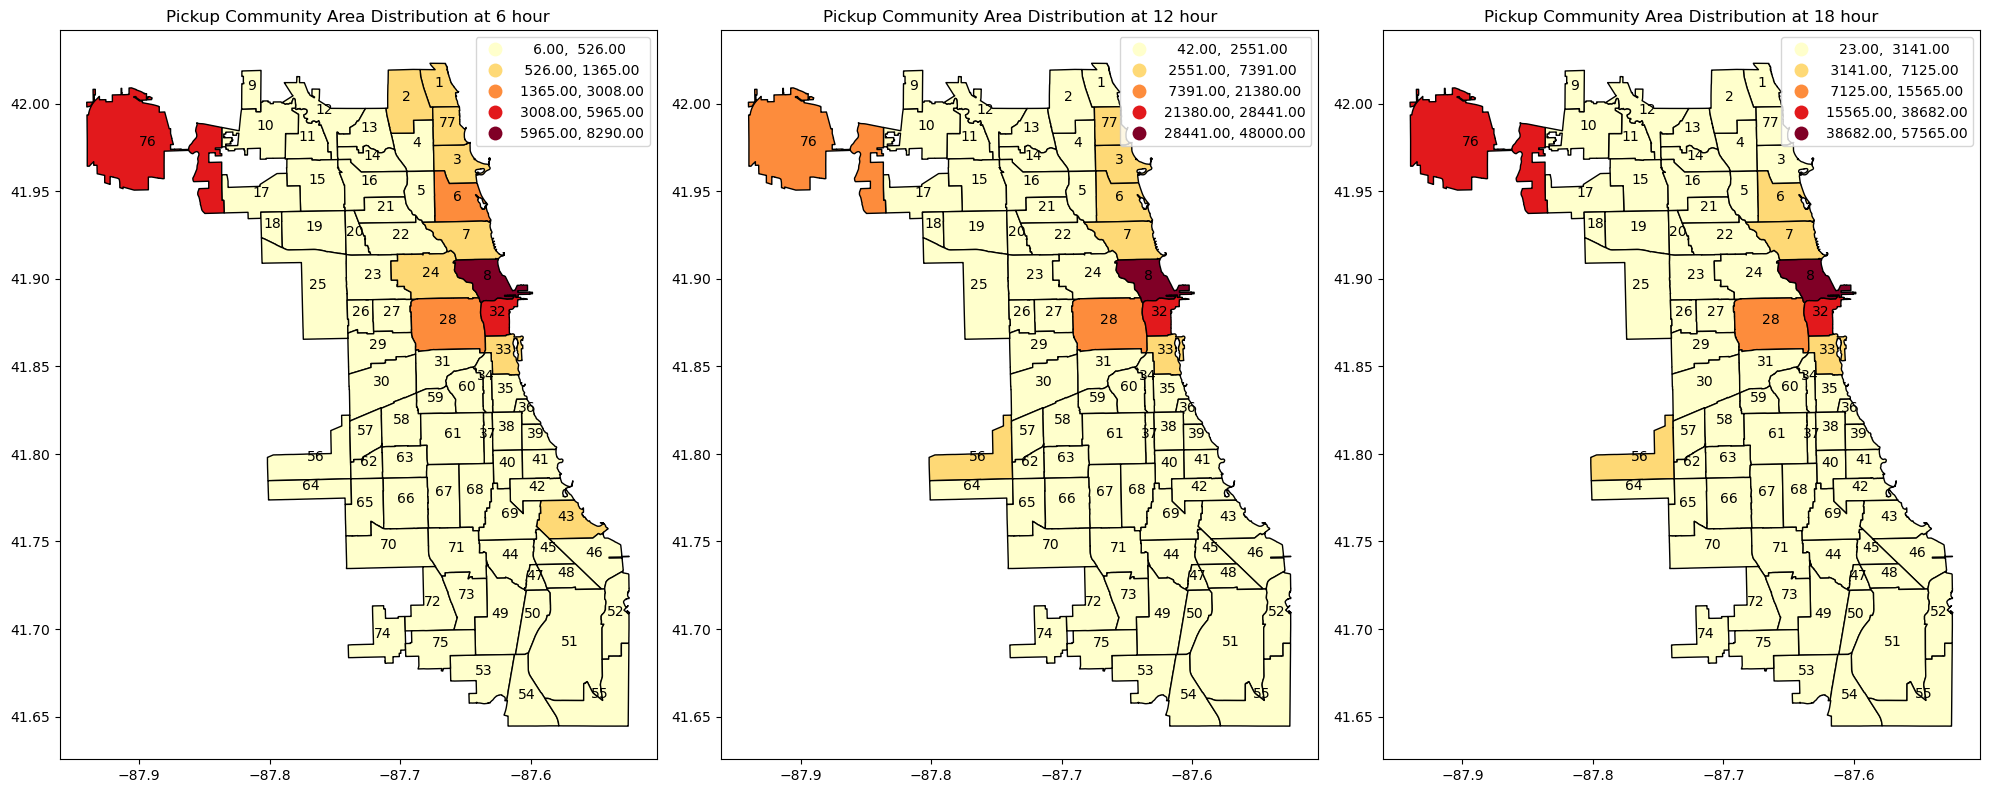

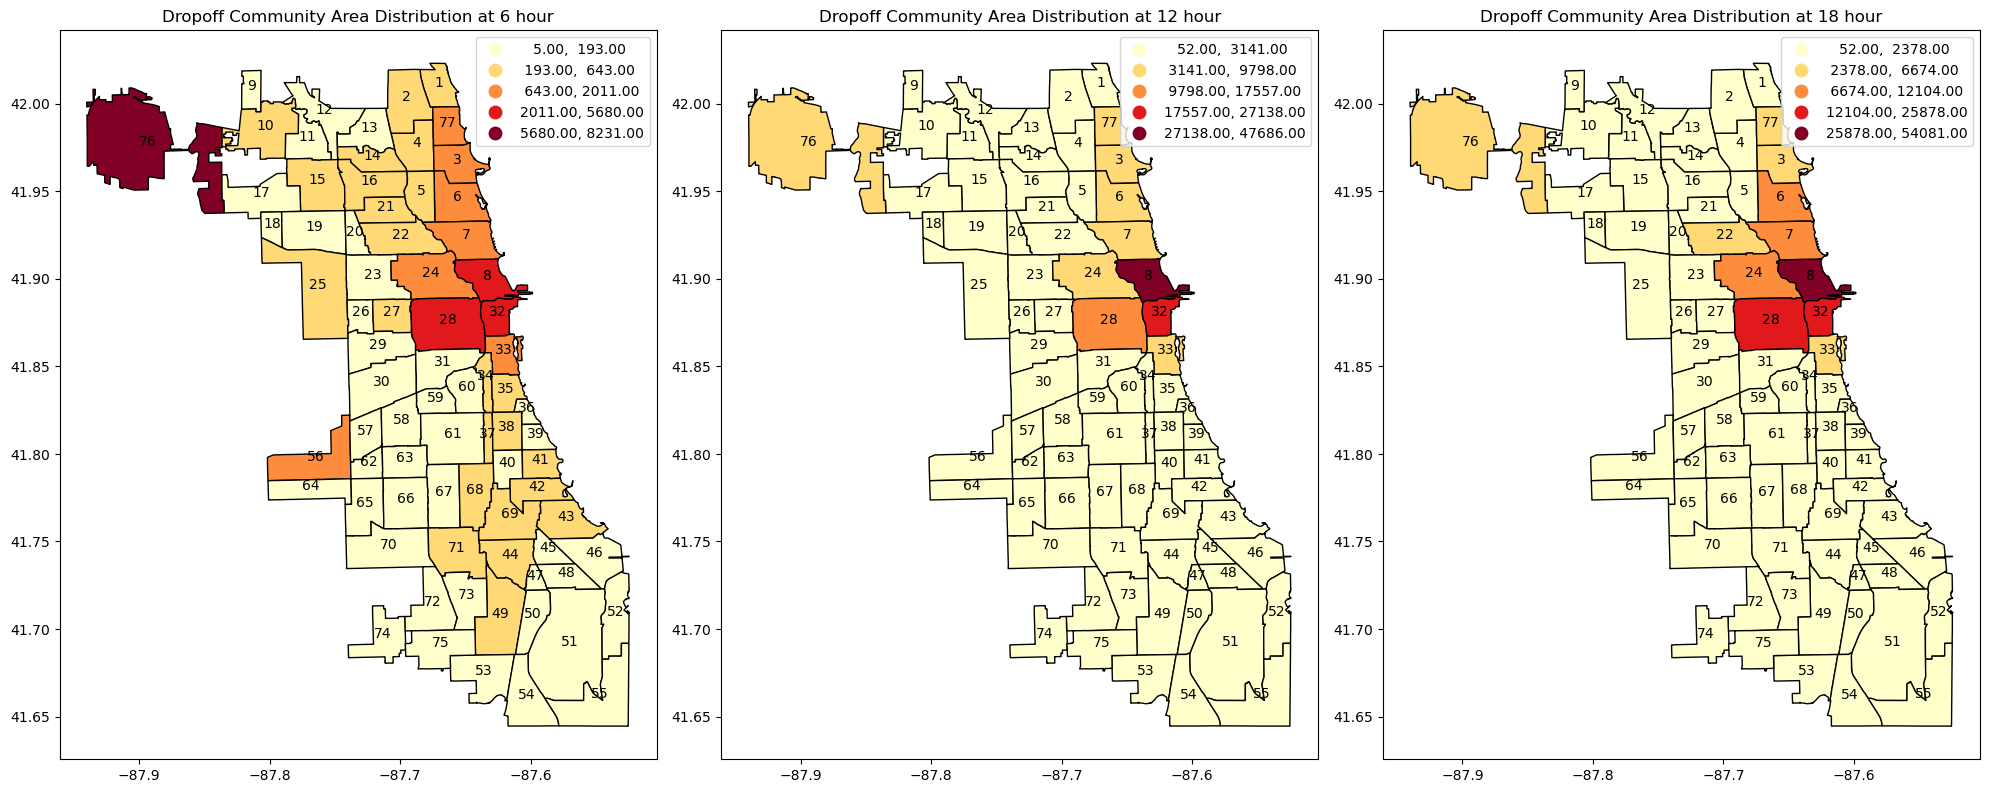

In [44]:
hours = [6, 12, 18]
visualize_community_trip_by_hour(df, ca, hours, 'pickup')
visualize_community_trip_by_hour(df, ca, hours, 'dropoff')

We see that the airport (the left-most district) has relatively constant number of pickup or dropoff throughout the day. The same observation can be made for the central part of the city while the pickup and dropoff activities on the southern part of the city seem to be concentrated in the morning. We will see if similar trend persists during pre-covid years

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



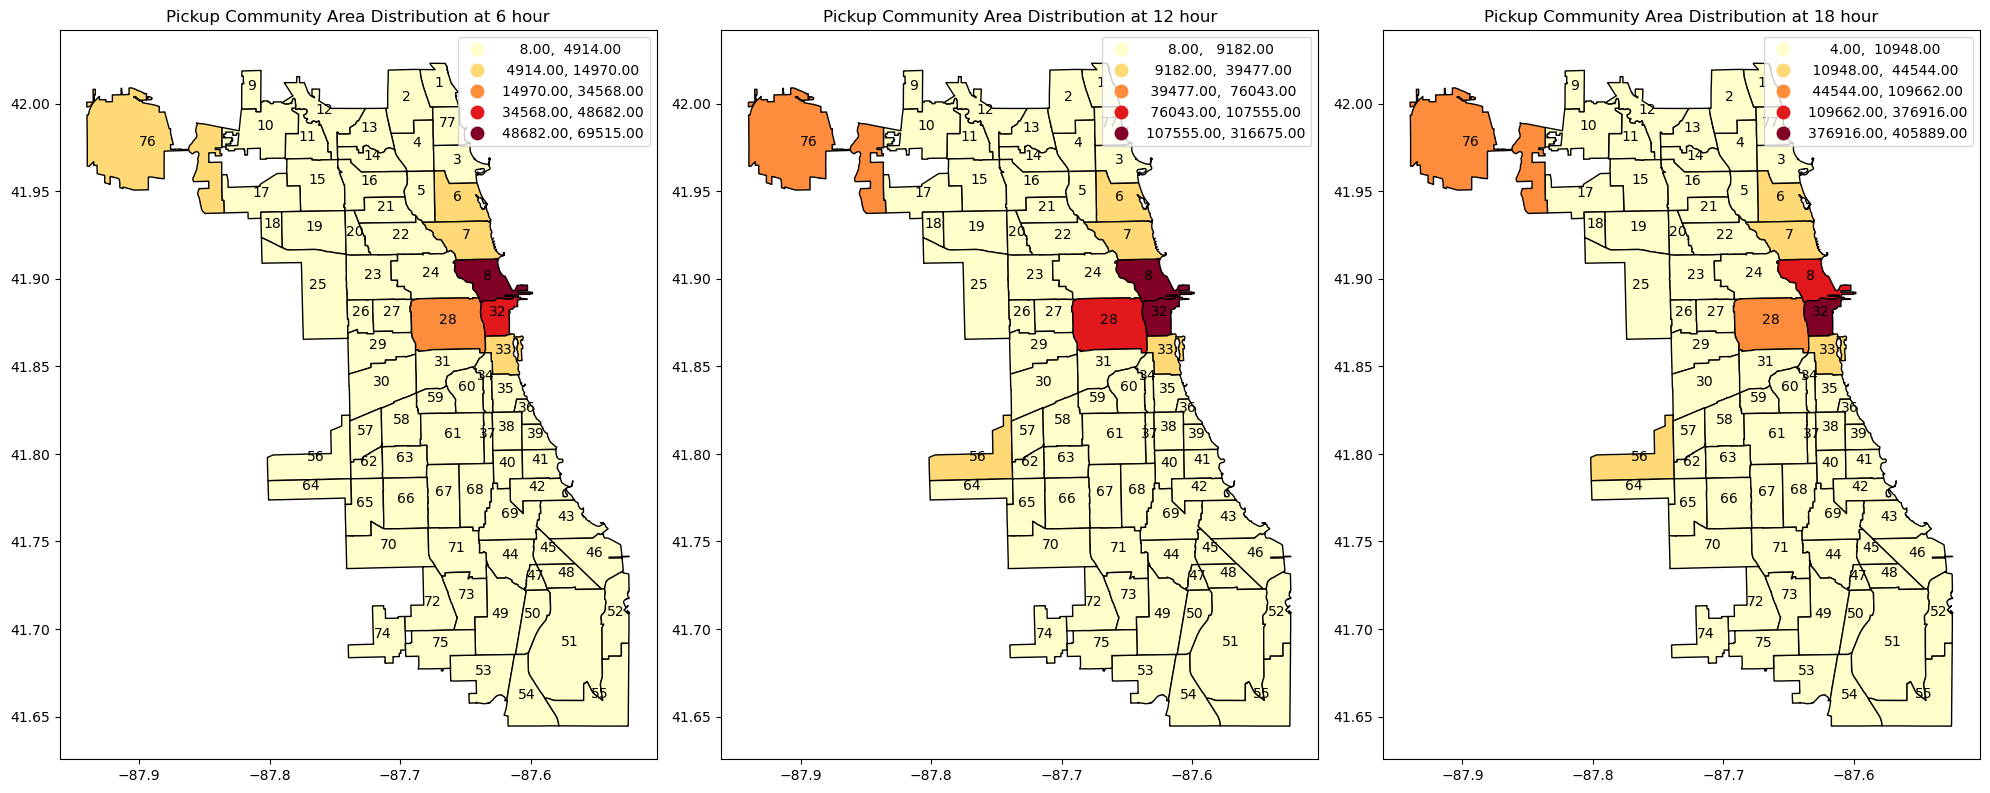

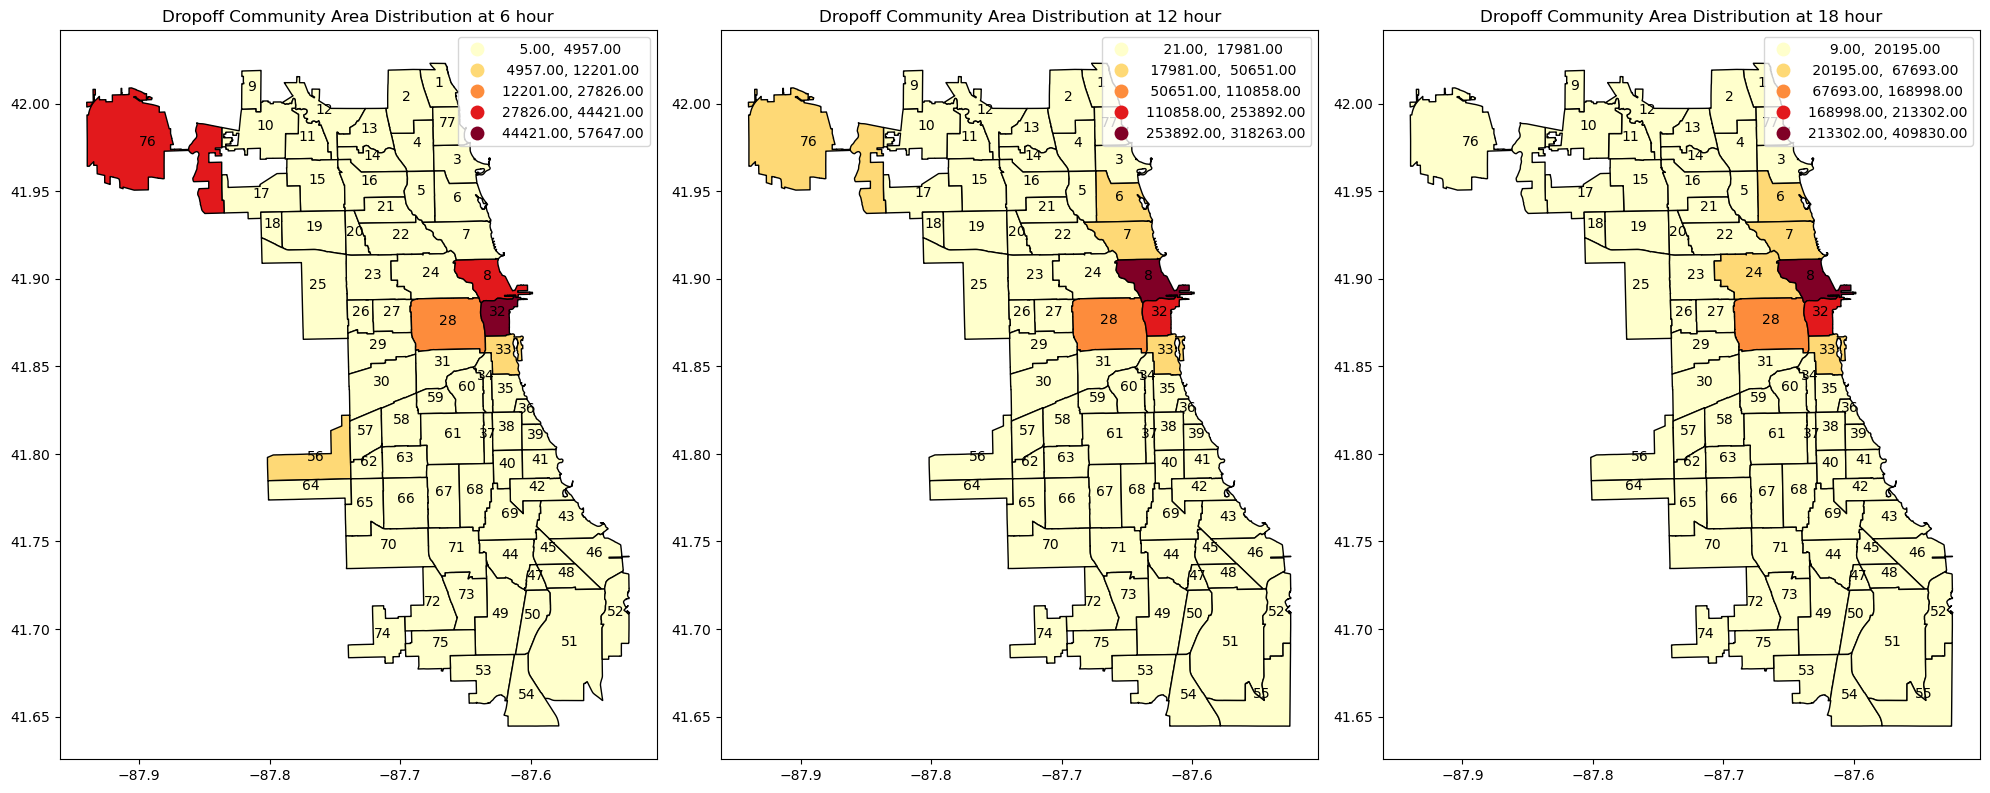

In [45]:
year = 2018
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'dropoff')

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



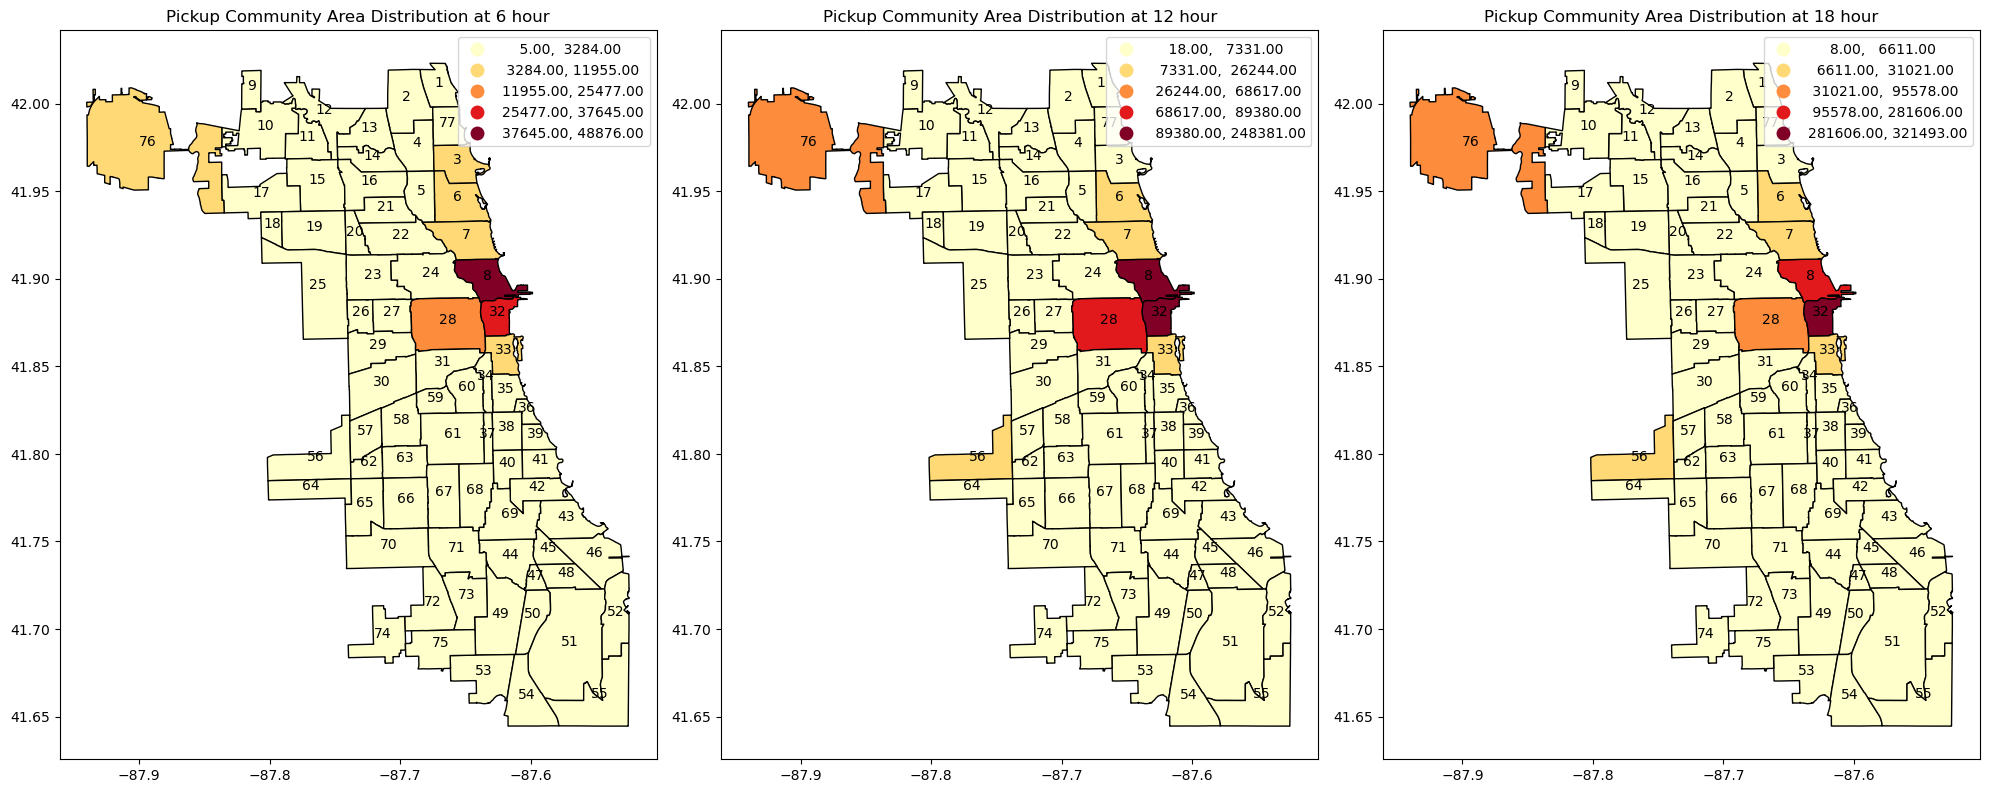

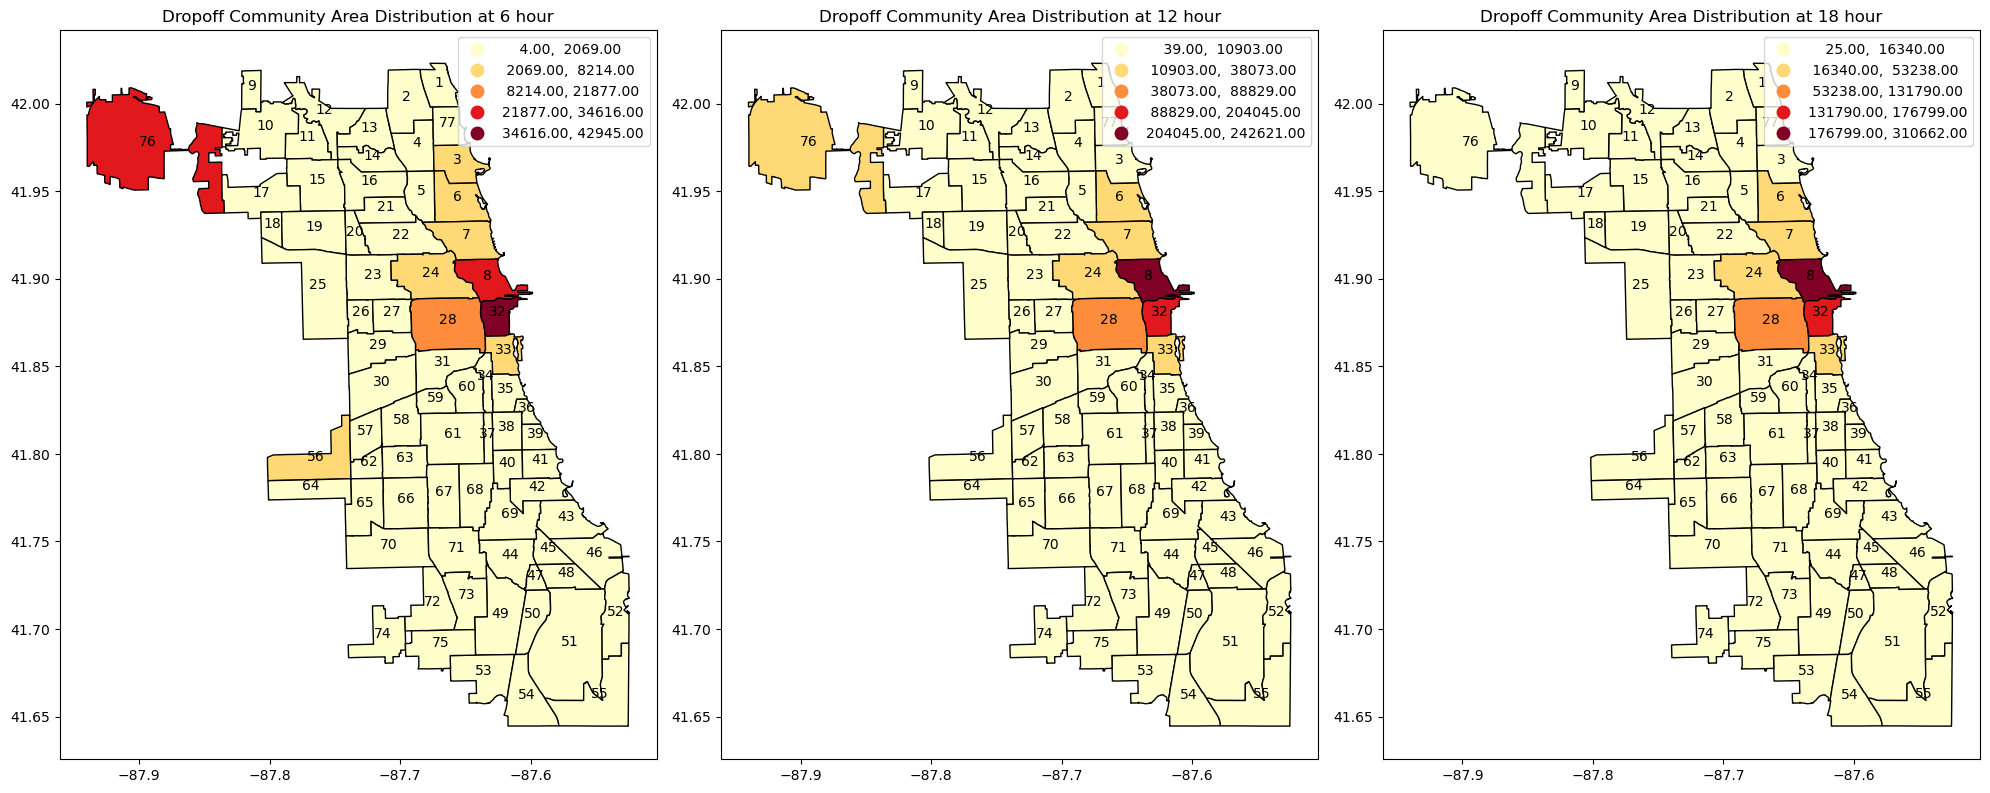

In [46]:
year = 2019
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'dropoff')

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



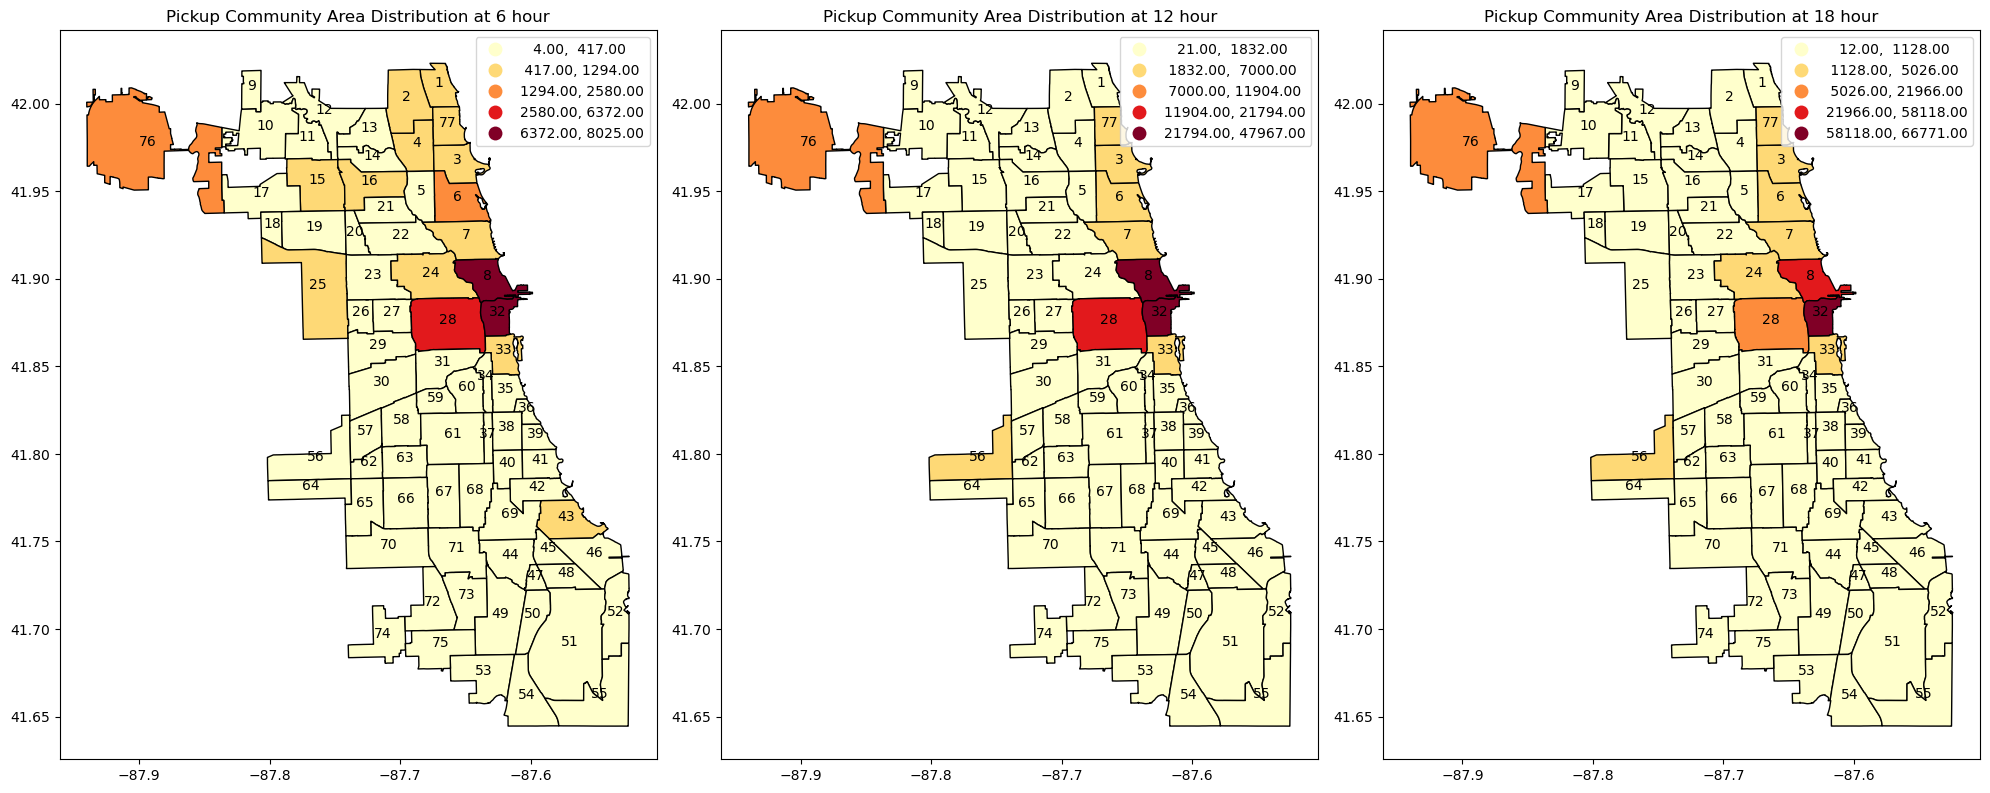

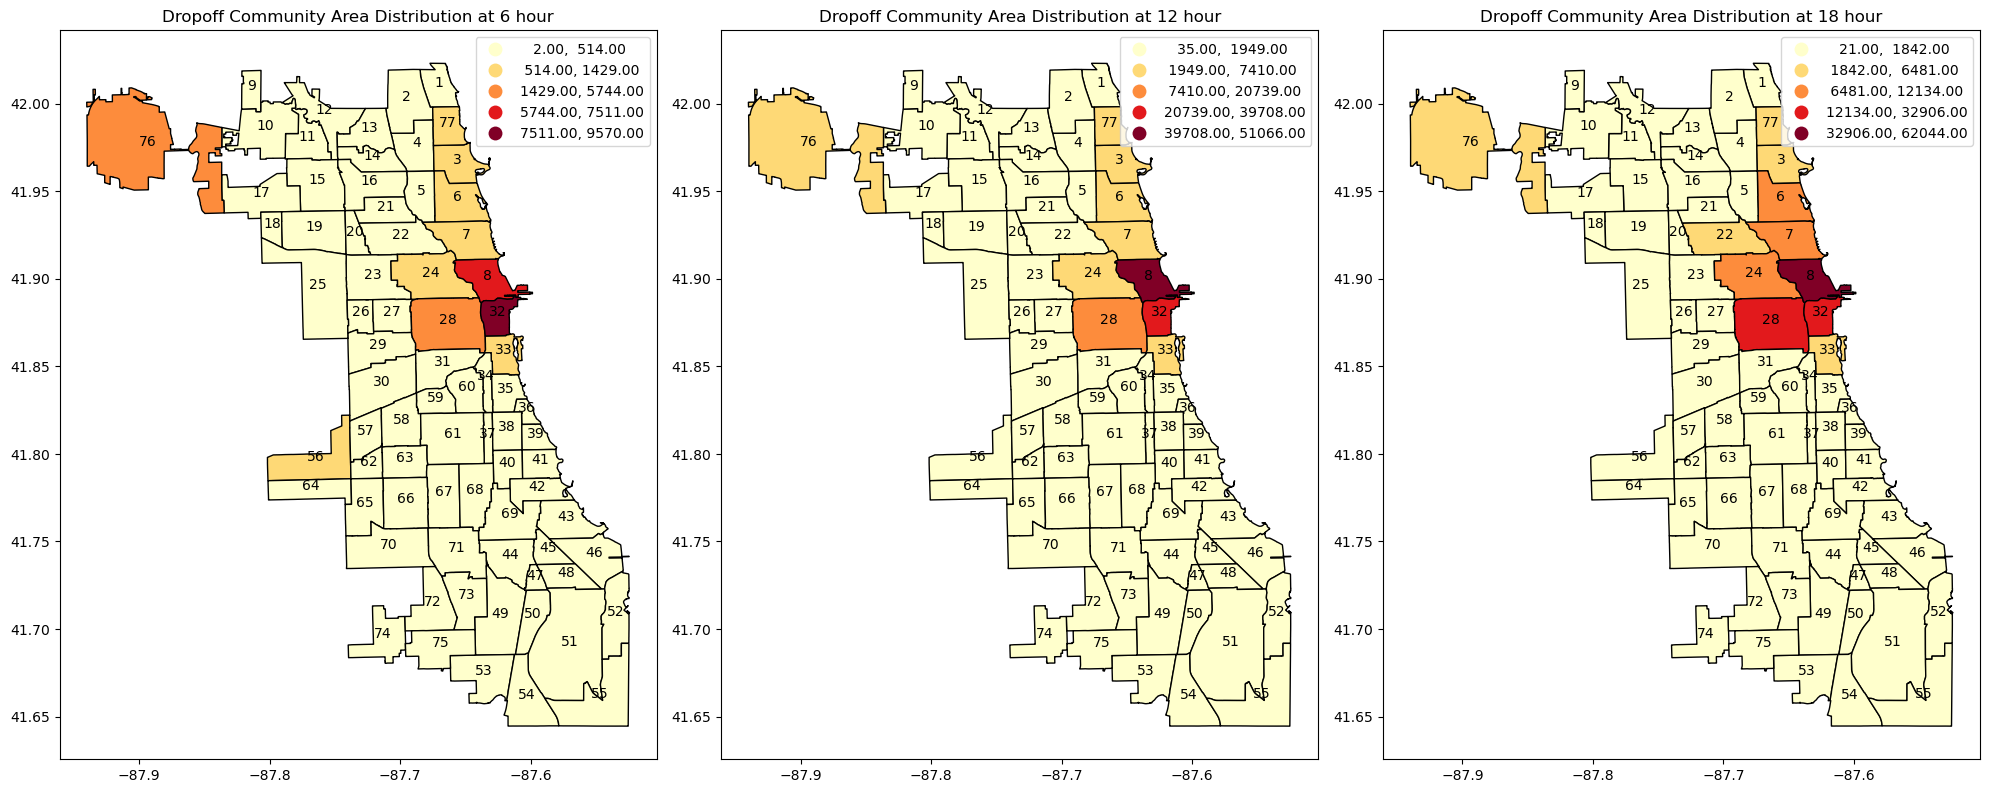

In [47]:
year = 2020
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_trip_by_hour(df_over_years[year], ca, hours, 'dropoff')

In [49]:
ca[ca['area_num_1'].isin([8, 28, 32, 36])]

community area     shape_area perimeter  area_num_1 area_numbe  \
1           OAKLAND    0  16913961.0408         0          36         36   
28   NEAR WEST SIDE    0  158492466.554         0          28         28   
36  NEAR NORTH SIDE    0  76675895.9728         0           8          8   
37             LOOP    0  46335565.4586         0          32         32   

   comarea_id comarea      shape_len  \
1           0       0  19565.5061533   
28          0       0  53003.5929406   
36          0       0  57293.1649516   
37          0       0  39428.6729962   

                                             geometry  
1   MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...  
28  MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...  
36  MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...  
37  MULTIPOLYGON (((-87.60949 41.88940, -87.60949 ...

In [52]:
def visualize_community_fare_by_hour(df, geo_df, hours, mode='pickup'):
    if mode not in ('pickup', 'dropoff'):
        raise ValueError('mode must be one of pickup or dropoff')
    
    if mode == 'pickup':
        col = 'Pickup Community Area'
    else:
        col = 'Dropoff Community Area'
    
    fig, axes = plt.subplots(1, len(hours), figsize=(20, 10 * len(hours)))
    
    if "hour" not in df.columns:
        df["hour"] = df["Trip Start Timestamp"].dt.hour
    

    dat_ca = df.groupby([col, "hour"])["Fare"].mean().reset_index()\
        .rename(columns={'Trip ID': 'Number of Trips'})
    dat_ca[col] = dat_ca[col].astype('int')
    
    merged_df = geo_df.merge(dat_ca, left_on='area_num_1', right_on=col)
    merged_df.fillna(value = 0, inplace=True)
    merged_df["center"] = merged_df["geometry"].centroid

    for hour, ax in zip(hours, axes):
        to_plot = merged_df[merged_df["hour"] == hour]
        to_plot.plot(column='Fare', scheme='fisher_jenks', cmap='YlOrRd', 
                     edgecolor='black',
                     legend=True, ax=ax)
        ax.set_title('Fare Distribution by {} at {} hour'.format(col, hour), fontdict={'fontsize': 12})
        
        for idx, row in to_plot.iterrows():
            ax.annotate(row['area_num_1'], (row['center'].x, row['center'].y),
                        horizontalalignment='center')

    plt.tight_layout()

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



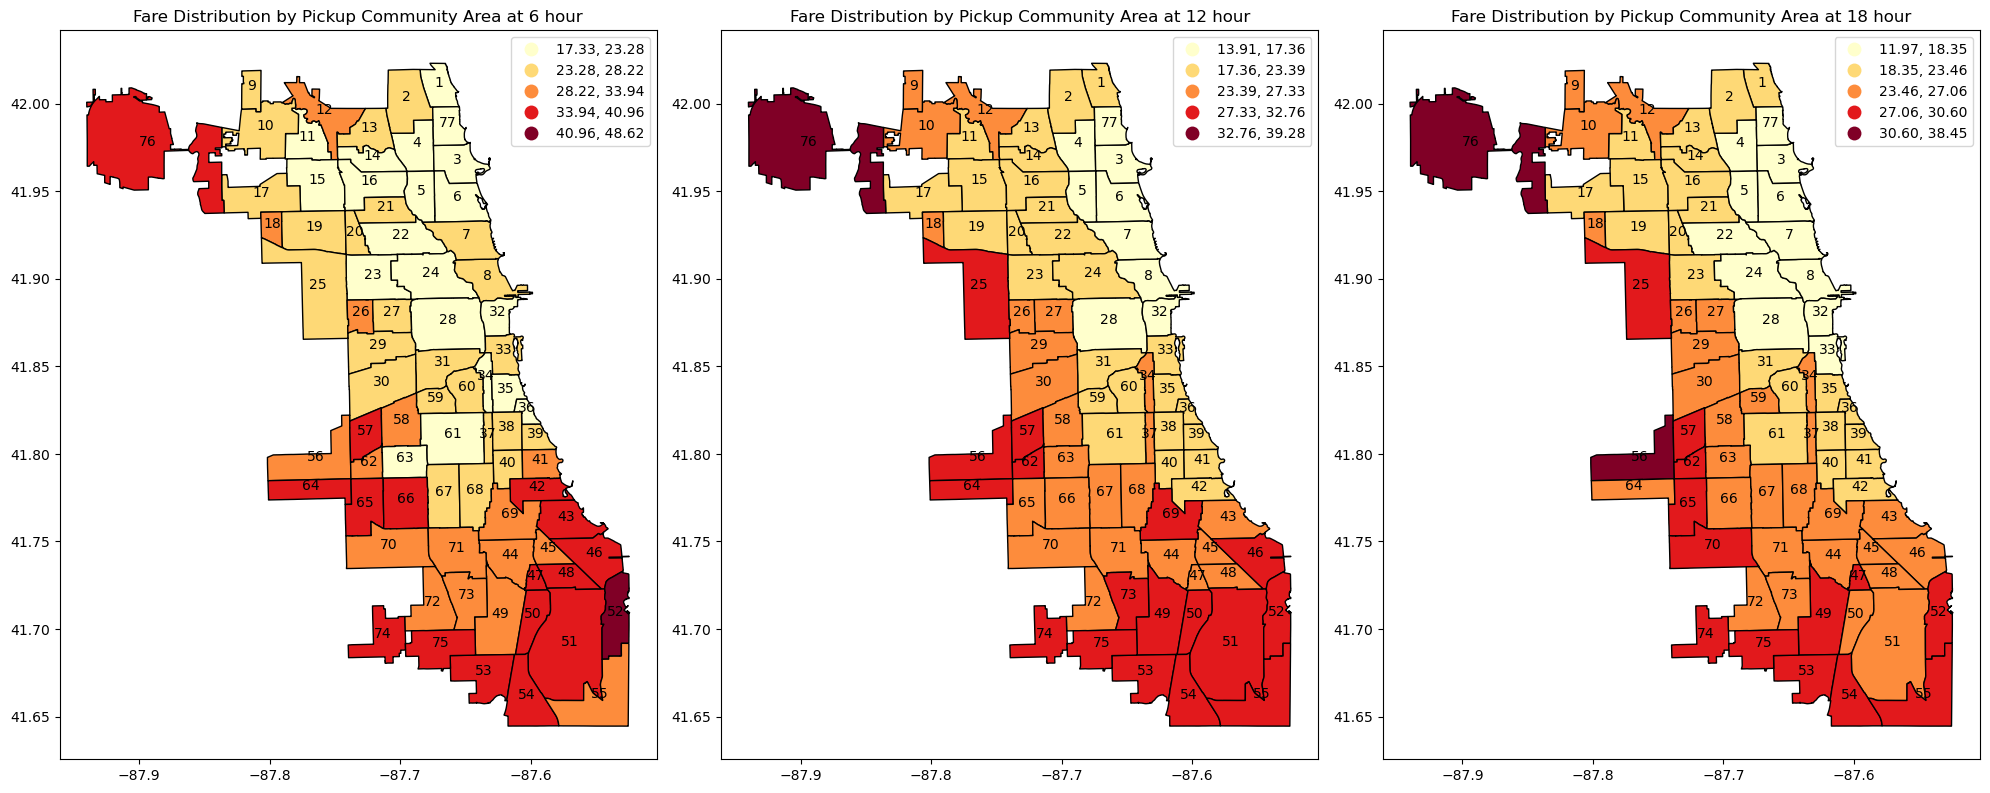

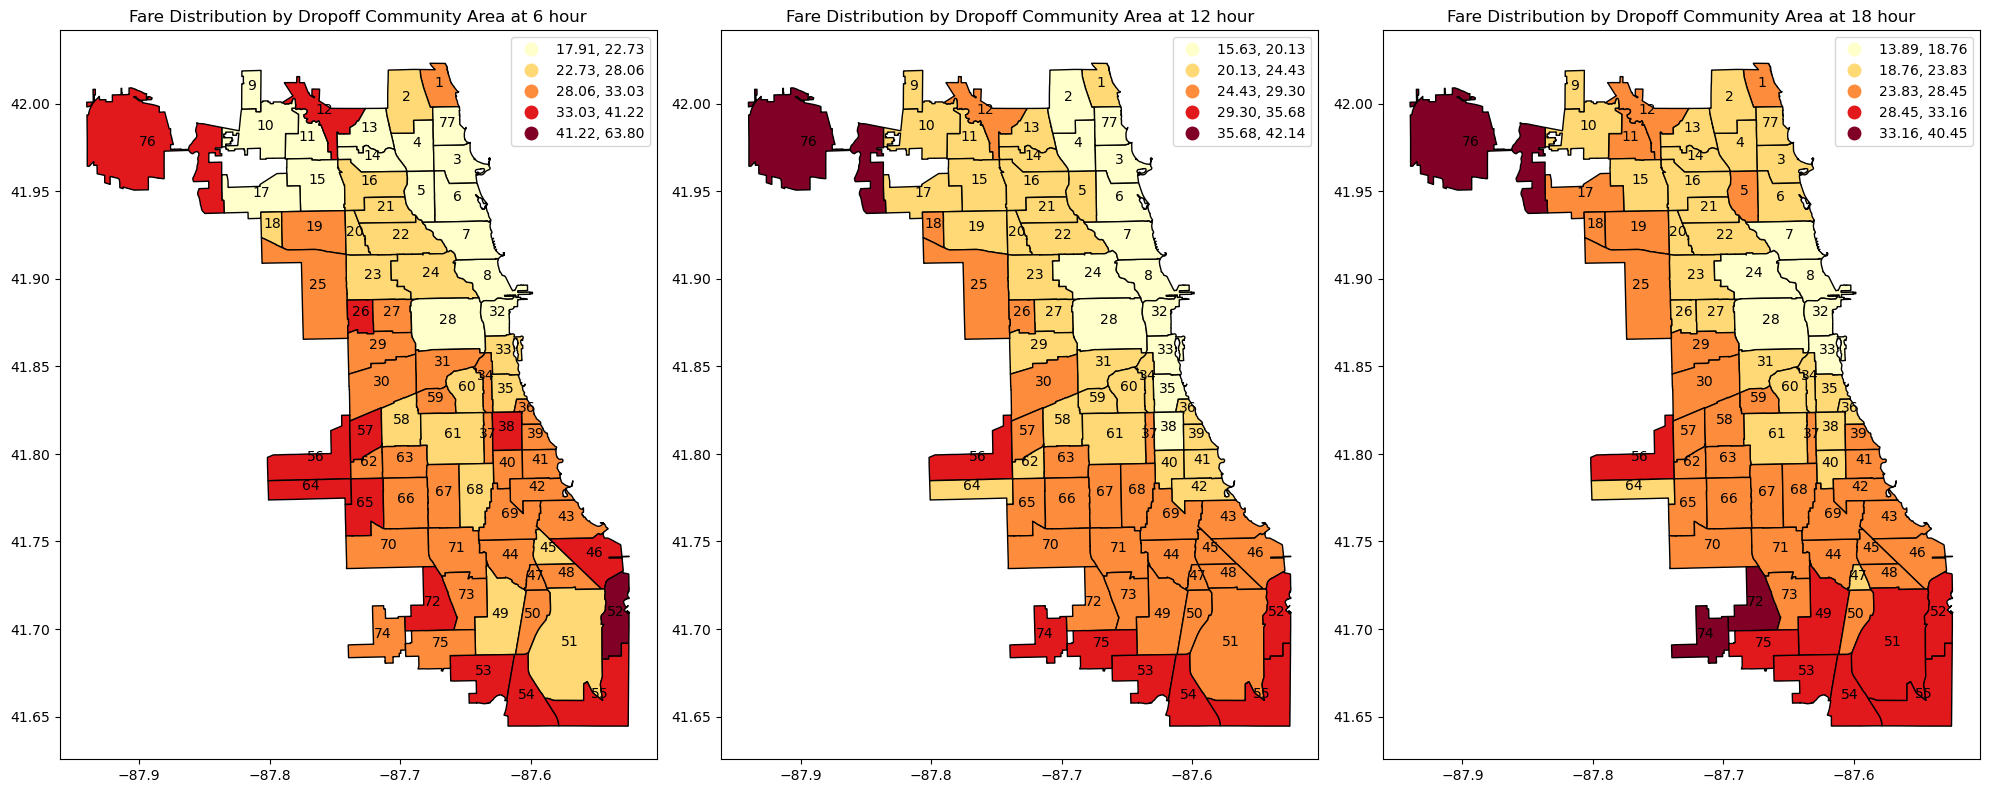

In [53]:
year = 2021
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'dropoff')

Since average fare is correlated with travel distance, it seems that the pickup and dropoff area at the southern part of the city is associated with longer travel. Airport average fare tends to be higher most of the time as well while average fares within the downtown area are generally lower despite the higher ride number, which suggests that within district commute is the norm for downtown area

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



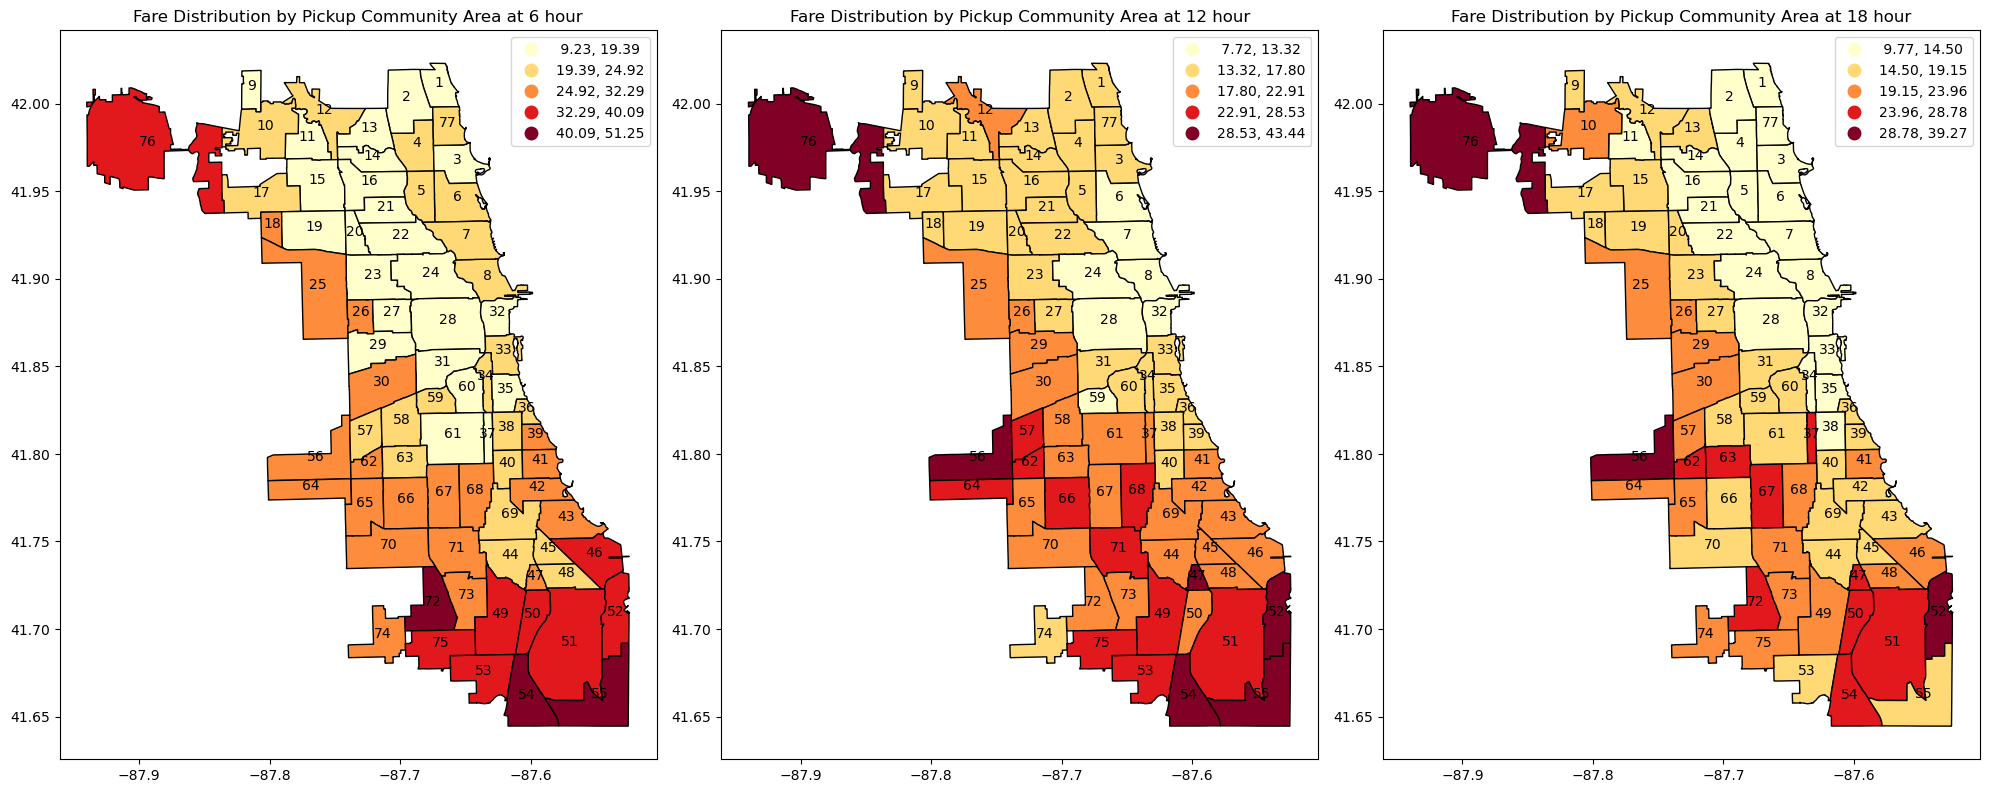

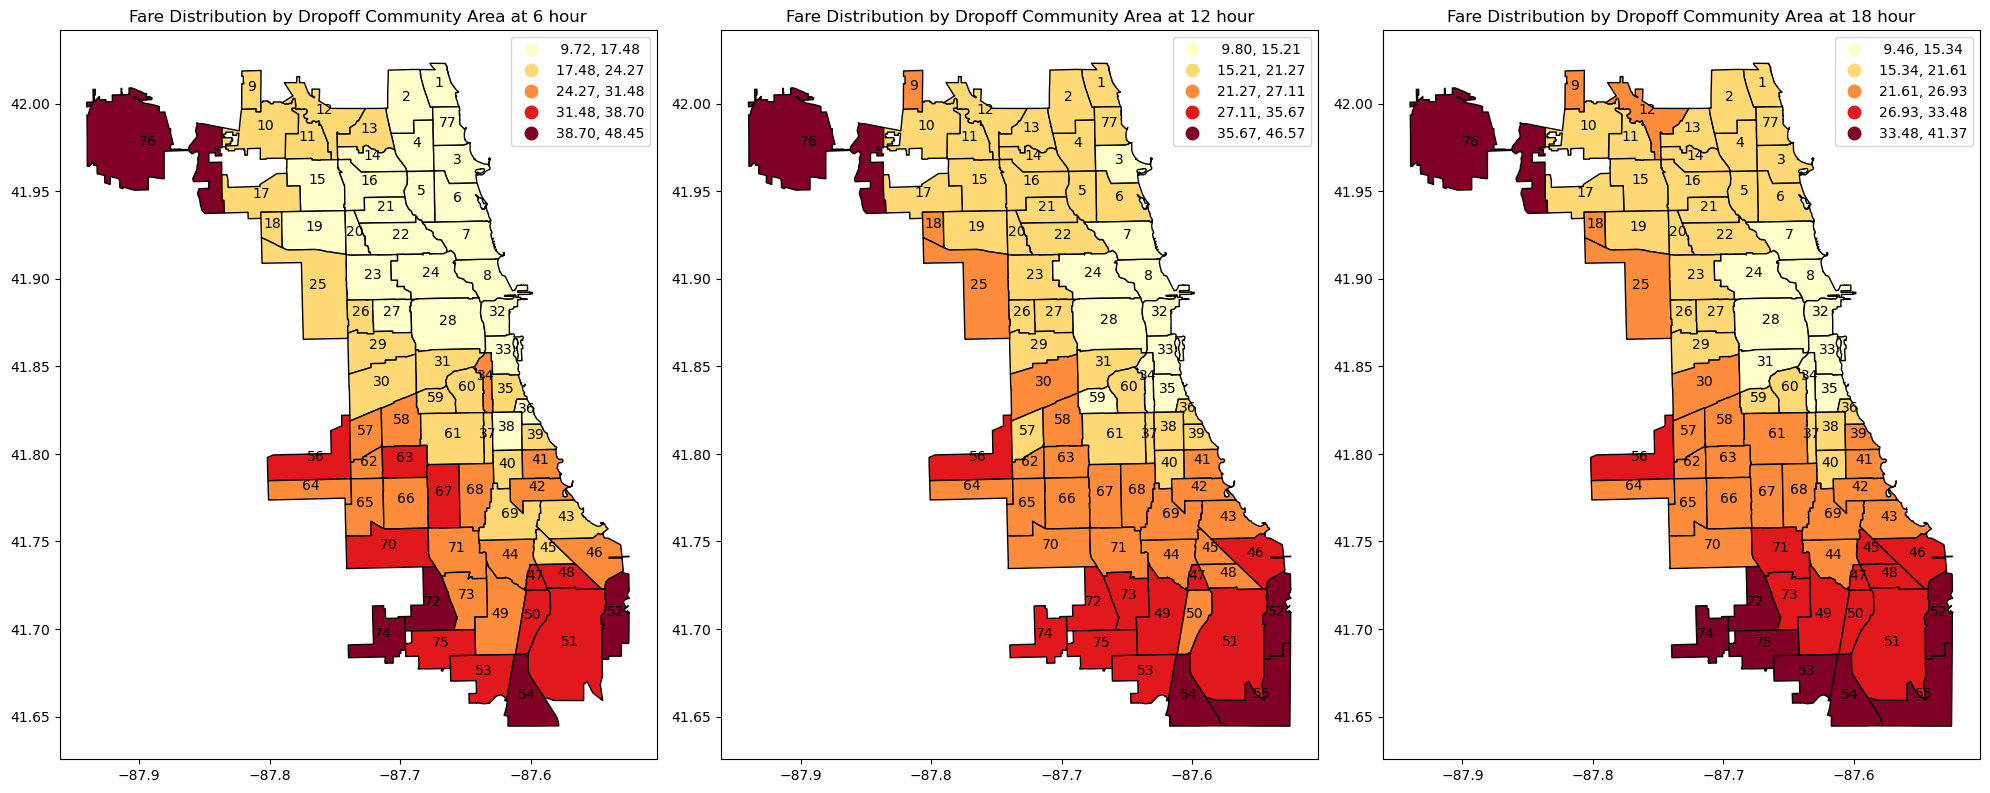

In [54]:
year = 2018
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'dropoff')

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



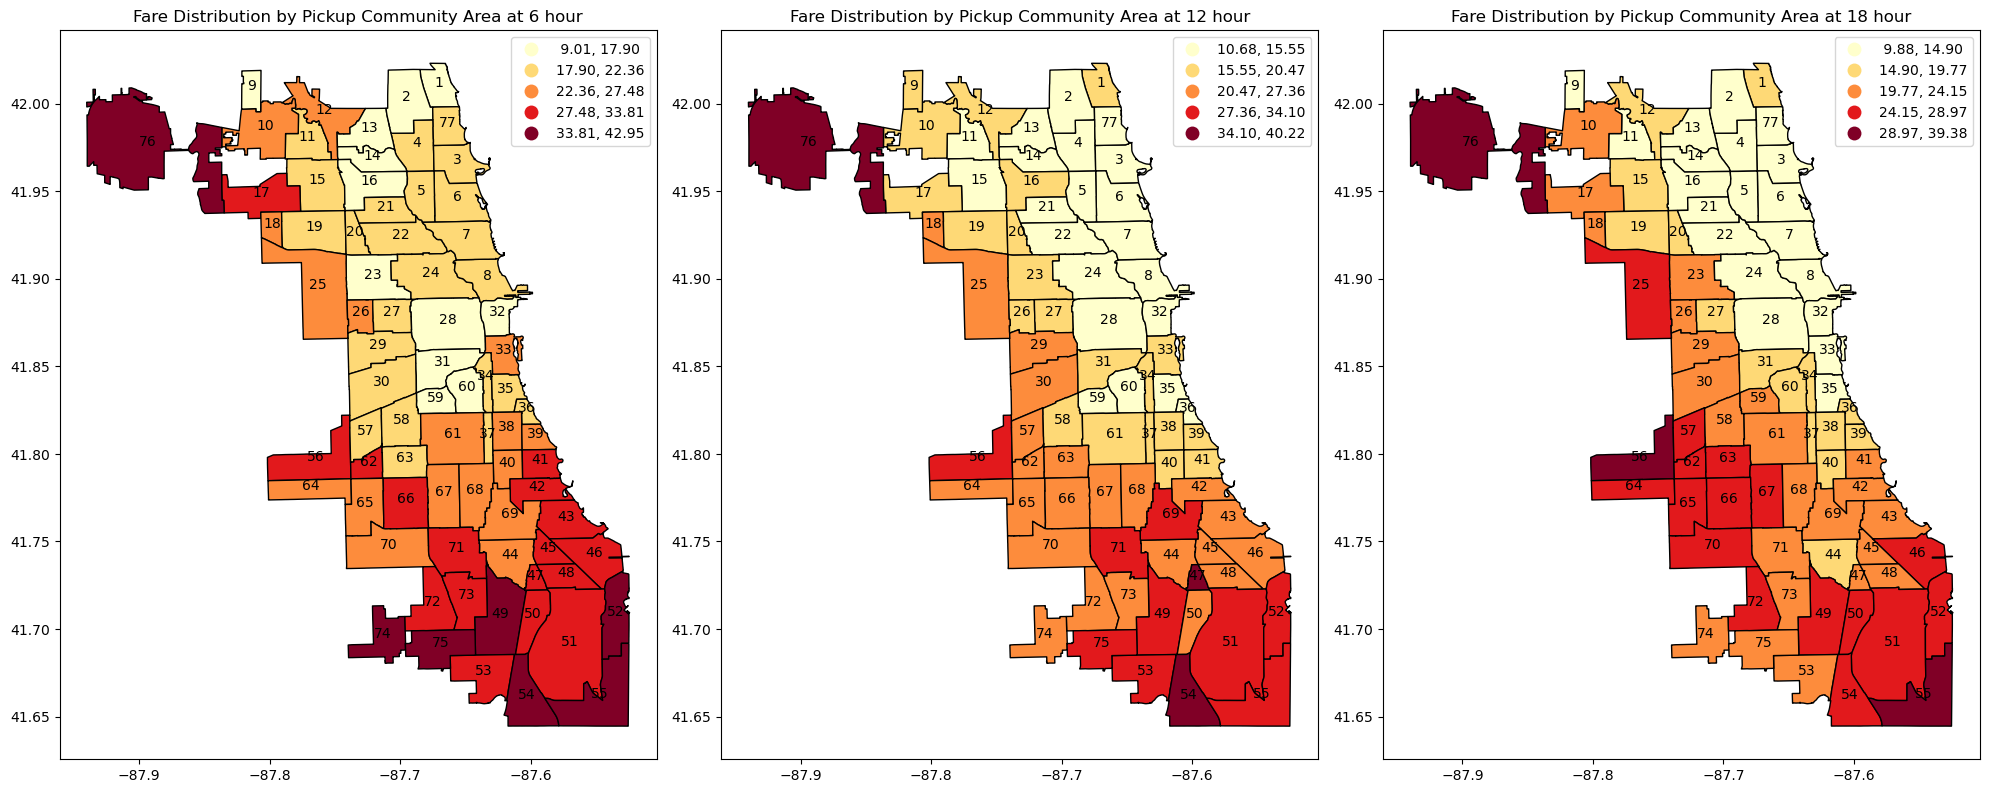

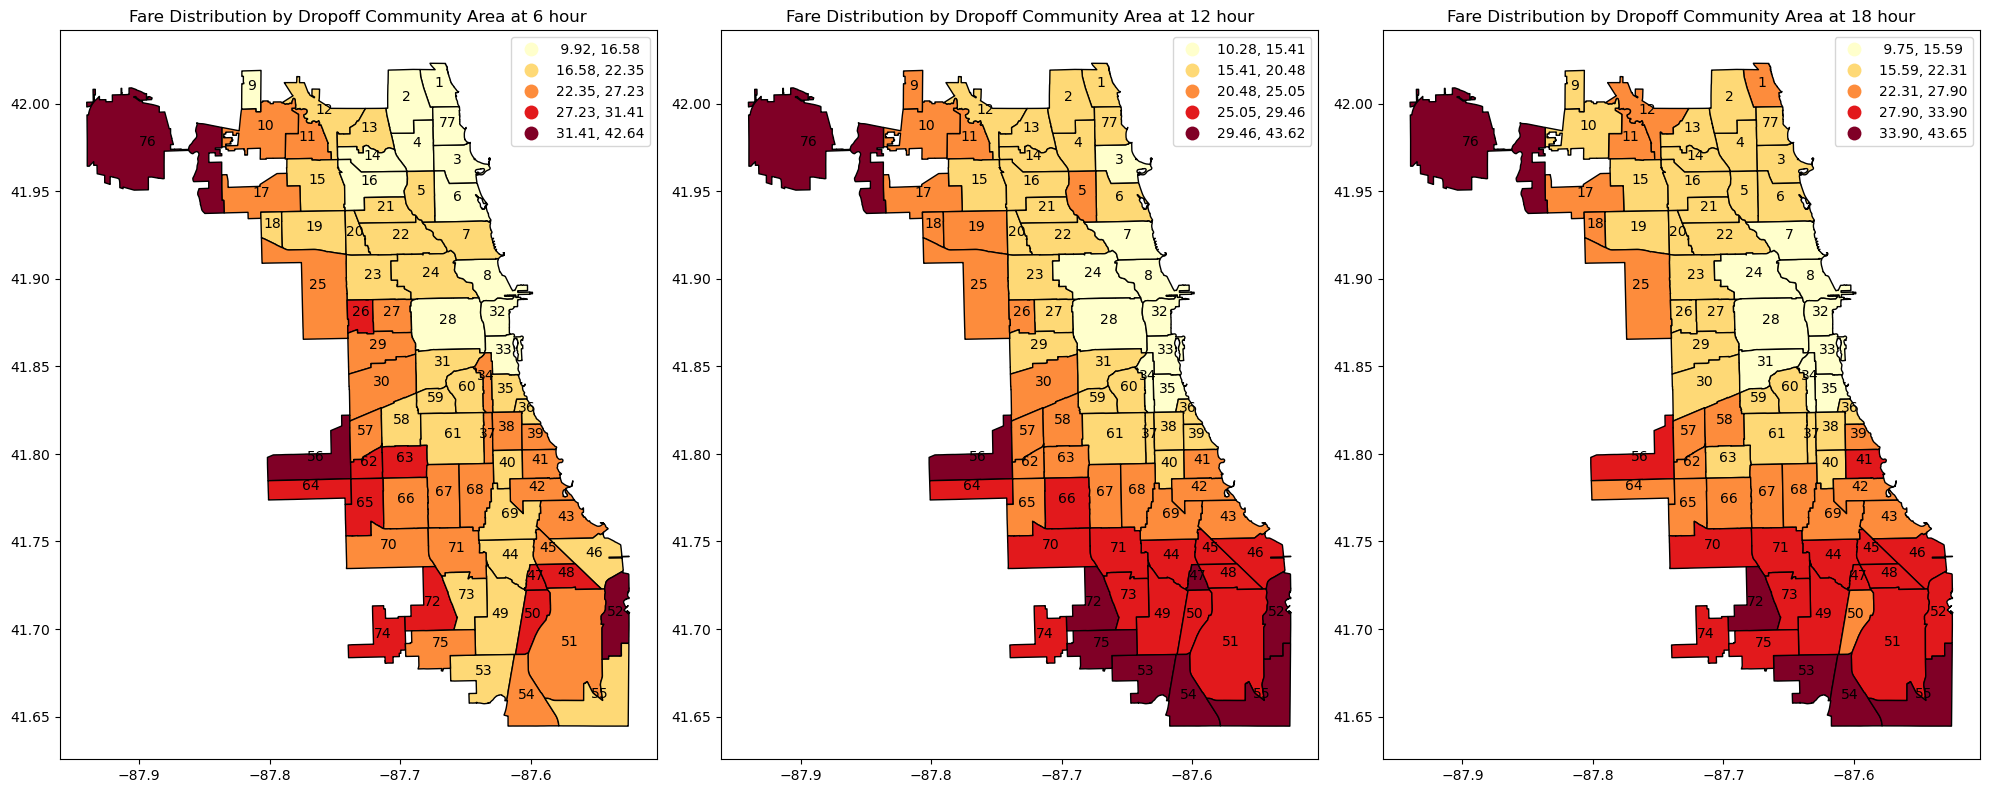

In [55]:
year = 2019
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'pickup')
visualize_community_fare_by_hour(df_over_years[year], ca, hours, 'dropoff')